In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
labor_train = pd.read_csv('train_preprocessed.csv', sep='\t', index_col=0)
labor_test = pd.read_csv('test_preprocessed.csv', sep='\t', index_col=0)

In [3]:
labor_train.head()

,indicator,er-cv,leukocyty,trombocyty,hemoglobin,ast,hematokrit
0,1.0,0.166667,0.401497,0.551966,0.742755,0.111111,0.322113
1,0.0,0.405000,0.525788,0.850466,0.096399,0.467167,0.767291
2,1.0,0.166667,0.812344,0.127427,0.278961,0.111111,0.213721
3,0.0,0.698214,0.787698,0.455711,0.888889,0.422187,0.512109
4,0.0,0.408464,0.944378,0.369594,0.128604,0.111111,0.255717


In [4]:
labor_test.describe()

,indicator,er-cv,leukocyty,trombocyty,hemoglobin,ast,hematokrit
count,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000,2472.000000
mean,0.634304,0.493736,0.502336,0.499681,0.498993,0.500286,0.504455
std,0.481722,0.280514,0.282626,0.283822,0.287940,0.284910,0.283972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.166667,0.246513,0.253332,0.251220,0.252247,0.251754
50%,1.000000,0.501564,0.508227,0.501003,0.500447,0.500071,0.502172
75%,1.000000,0.833333,0.748037,0.749898,0.744506,0.750488,0.742400
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


1. Leukocyty
2. Hematokrit
3. Hemoglobin
4. Er-cv
5. Trombocyty
6. Ast

# 1. OneR algoritmus

In [5]:
def one_r(df, atributes):
    """
    OneR algoritmus dostane trenovaci a testovaci dataset a atributy
    postupne prechadza atributy a rozdeli mnozinu (0; 1) na intervaly po 0.1
    pre kazdu tuto triedu zrata kolko indikatorov je 1 a kolko 0, pre 1 prirata
    a pre 0 odrata jednotu od hodnoty v poli arr[] (pole arr reprezentuje hodnotu pre kazdu triedu daneho atributu)
    
    Nasledne sa prechadza znovu trenovaci dataset, pre kazdu hodnotu sa priradi indicator a porovna z uz danym indikatorom
    Takto sa pre kazdy atribut vyrata hodnota accuracy, a na konci sa zoberie atribut s najvacsou accuracy
    a pole hodnot pre kazdu triedu tohoto atributu
    """
    arr_accuracy = [0] * len(atributes)
    arr_all = []
    for index, atribute in enumerate(atributes):
        arr = [0]*10
        accuracy = 0
        for i, row in df.iterrows():
            for j in range(10):
                if j/10 <= row[atribute] < (j+1)/10:
                    if row["indicator"] == 1:
                        arr[j] += 1
                    else:
                        arr[j] -= 1
        for i, row in df.iterrows():
            for j in range(10):
                if j/10 <= row[atribute] < (j+1)/10:
                    if arr[j] > 0:
                        if row['indicator'] == 1:
                            accuracy += 1
                        else:
                            accuracy -= 1
                    else:
                        if row['indicator'] == 0:
                            accuracy += 1
                        else:
                            accuracy -= 1
        print(arr)
        print(f"accuracy: {accuracy}")
        arr_all.append(arr.copy())
        arr_accuracy[index] = accuracy
        print()
    return (atributes[arr_accuracy.index(max(arr_accuracy))], arr_all[arr_accuracy.index(max(arr_accuracy))])


def use_one_r(new, target_atribute, result):
    """
    Use OneR dostane nove data, ktore maju byt klasifikovane, atribut s najvacsou accuracy a result (pole hodnot atributu)
    Najde triedu do ktorej patri nova hodnota (v target_atribut) a vrati hodnotu jeho indicatora (0 alebo 1)
    """
    for j in range(10):
        if j/10 <= new[target_atribute] < (j+1)/10:
            if result[j] > 0:
                return 1
            else:
                return 0
    return 1
            
# tymto sposobom mi staci jeden krat natrenovat algoritmus, a mozem ho potom rychlo vela krat pouzit

In [6]:
target_atribute, target_arr = one_r(labor_train, ['leukocyty', 'hematokrit', 'hemoglobin', 'er-cv', 'trombocyty', 'ast'])

[490, 753, 661, 385, 2, -63, -40, -38, -44, 55]
accuracy: 2531

[237, 1040, 406, 283, 110, 35, 1, 12, -10, 47]
accuracy: 2181

[355, 396, 378, 375, 383, 323, 273, 196, -427, -91]
accuracy: 3197

[139, 468, 77, 194, 194, 260, 178, 99, 457, 97]
accuracy: 2163

[235, 255, 210, 176, 238, 212, 238, 238, 183, 178]
accuracy: 2163

[0, 407, 168, 217, 238, 243, 225, 182, 451, 30]
accuracy: 2161



In [7]:
"""
V cykle prechadzam testovaci dataset a pustam ho do funkcie use_one_r po riadkoch
Na konci zratam, kolko hodnot bolo priradenych spravne
"""
y_true = []
y_pred = []
for i, row in labor_test.iterrows():
    if use_one_r(row, target_atribute, target_arr) == None:
        print("now")
        use_one_r(row, target_atribute, target_arr)
    y_pred.append(use_one_r(row, target_atribute, target_arr))
    y_true.append(int(row['indicator']))

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Accuracy = ", accuracy_score(y_true, y_pred))
print("Precision = ", precision_score(y_true, y_pred))
print("Recall = ", recall_score(y_true, y_pred))

Accuracy =  0.7148058252427184
Precision =  0.7211686314710405
Recall =  0.8973214285714286


# 2. Natrénovanie strojového učenia - stromový algoritmus
Vytvorenie funkcie pre natrénovanie a následné otestovanie algoritmu decision tree

In [10]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [11]:
X_train = labor_train[['er-cv','leukocyty','trombocyty','hemoglobin','ast','hematokrit']]
y_train = labor_train[['indicator']]

In [12]:
X_test = labor_test[['er-cv','leukocyty','trombocyty','hemoglobin','ast','hematokrit']]
y_test = labor_test[['indicator']]

In [13]:
X_train

,er-cv,leukocyty,trombocyty,hemoglobin,ast,hematokrit
0,0.166667,0.401497,0.551966,0.742755,0.111111,0.322113
1,0.405000,0.525788,0.850466,0.096399,0.467167,0.767291
2,0.166667,0.812344,0.127427,0.278961,0.111111,0.213721
3,0.698214,0.787698,0.455711,0.888889,0.422187,0.512109
4,0.408464,0.944378,0.369594,0.128604,0.111111,0.255717
...,...,...,...,...,...,...
7411,0.166667,0.078640,0.755602,0.278672,0.833333,0.980660
7412,0.833333,0.341716,0.792409,0.375579,0.833333,0.617682
7413,0.570789,0.511191,0.041743,0.472727,0.833333,0.130750
7414,0.336835,0.587366,0.141449,0.701149,0.501854,0.214179


In [21]:
def predict_tree(i):
    if (i == 0):
        clf = DecisionTreeClassifier()
    else:
        print("Depth = ",i)
        clf = DecisionTreeClassifier(max_depth = i)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

In [22]:
strom = predict_tree(0)

Accuracy =  0.8252427184466019  Precision =  0.8554443053817271  Recall =  0.8718112244897959


Ako vidíme strom má presnosť 82% a zvyšné metriky Precision a Recall okolo 86%

In [16]:
strom.tree_.max_depth

26

Strom má hĺbku 26 a pri vizualizácií vidíme, že pri aktuálnej veľkosti je veľmi neprehľadný

[Text(288.0406411957586, 640.24, 'X[1] <= 0.381\ngini = 0.458\nsamples = 7416\nvalue = [2627, 4789]'),
 Text(148.9002510219203, 616.08, 'X[5] <= 0.926\ngini = 0.188\nsamples = 2868\nvalue = [301, 2567]'),
 Text(102.00803938045179, 591.9200000000001, 'X[1] <= 0.352\ngini = 0.122\nsamples = 2412\nvalue = [157, 2255]'),
 Text(68.28849257215956, 567.76, 'X[3] <= 0.0\ngini = 0.1\nsamples = 2223\nvalue = [117, 2106]'),
 Text(67.38610945141372, 543.6, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(69.1908756929054, 543.6, 'X[3] <= 0.809\ngini = 0.099\nsamples = 2222\nvalue = [116, 2106]'),
 Text(31.953417148783174, 519.44, 'X[5] <= 0.36\ngini = 0.086\nsamples = 1937\nvalue = [87, 1850]'),
 Text(5.865490284847943, 495.2800000000001, 'X[0] <= 0.087\ngini = 0.038\nsamples = 518\nvalue = [10, 508]'),
 Text(2.7071493622375122, 471.12000000000006, 'X[0] <= 0.086\ngini = 0.147\nsamples = 25\nvalue = [2, 23]'),
 Text(1.8047662414916747, 446.96000000000004, 'X[0] <= 0.073\ngini = 0.08\nsamples = 24

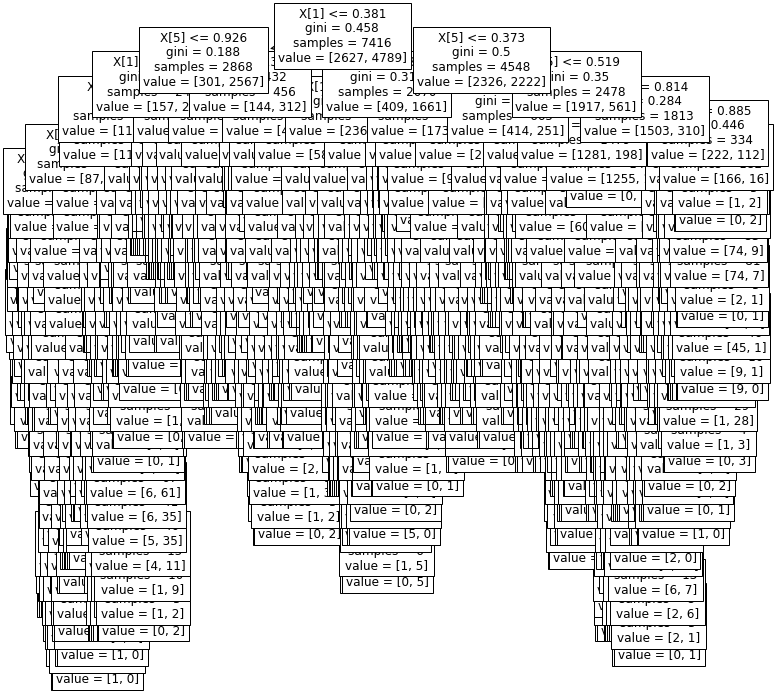

In [23]:
plt.figure(figsize=(12,12))
tree.plot_tree(strom,fontsize = 12)

# 3. Hyperparameter tuning

1. max_depth = limituje hĺbku maximálnou hodnotou
2. min_samples_leaf = minimálny počet samplov na 1 liste
3. max_leaf_nodes = maximálny konečný počet listov
4. max_features = určuje počet parametrov ktoré sa náhodne vyberú a použijú pri rozdelovaní

In [24]:
lst = []
for i in range(1,30):
    lst.append(predict_tree(i))

Depth =  1
Accuracy =  0.6678802588996764  Precision =  0.890282131661442  Recall =  0.5433673469387755
Depth =  2
Accuracy =  0.8305016181229773  Precision =  0.8496652465003043  Recall =  0.8903061224489796
Depth =  3
Accuracy =  0.8543689320388349  Precision =  0.8886743886743886  Recall =  0.8807397959183674
Depth =  4
Accuracy =  0.8543689320388349  Precision =  0.8856960408684547  Recall =  0.8845663265306123
Depth =  5
Accuracy =  0.8559870550161812  Precision =  0.8594306049822064  Recall =  0.9241071428571429
Depth =  6
Accuracy =  0.8499190938511327  Precision =  0.8522660388463802  Recall =  0.923469387755102
Depth =  7
Accuracy =  0.863673139158576  Precision =  0.8883280757097792  Recall =  0.8979591836734694
Depth =  8
Accuracy =  0.8640776699029126  Precision =  0.8893805309734514  Recall =  0.8973214285714286
Depth =  9
Accuracy =  0.8523462783171522  Precision =  0.8669920683343502  Recall =  0.90625
Depth =  10
Accuracy =  0.8551779935275081  Precision =  0.8800251256

Najlepšie vyšla presnosť hĺbkam medzi 3 a 10, pri čom, najlepšia bola hĺbka = 8
Najlepší precision bol v hĺbkach 1,3,7,8 a najlepší recall v 5,6,7,8
Teda pri skúšaní ďaľších parametrov sa budeme sústrediť na hĺbku od 3 po 8
Ďalej sa pozrieme na parameter min_samples_leaf ktorý určuje minimálny počet vzorky na liste

In [25]:
def predict_tree_MinSample(i,j):
    print("Depth = ",i," Min sample leaf = ",j)
    clf = DecisionTreeClassifier(max_depth = i,min_samples_leaf = j)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

In [26]:
for j in range (1,400,50):
    for i in range(3,9):
        predict_tree_MinSample(i,j)

Depth =  3  Min sample leaf =  1
Accuracy =  0.8543689320388349  Precision =  0.8886743886743886  Recall =  0.8807397959183674
Depth =  4  Min sample leaf =  1
Accuracy =  0.8543689320388349  Precision =  0.8856960408684547  Recall =  0.8845663265306123
Depth =  5  Min sample leaf =  1
Accuracy =  0.8559870550161812  Precision =  0.8594306049822064  Recall =  0.9241071428571429
Depth =  6  Min sample leaf =  1
Accuracy =  0.8499190938511327  Precision =  0.8522660388463802  Recall =  0.923469387755102
Depth =  7  Min sample leaf =  1
Accuracy =  0.863673139158576  Precision =  0.8883280757097792  Recall =  0.8979591836734694
Depth =  8  Min sample leaf =  1
Accuracy =  0.8644822006472492  Precision =  0.889943074003795  Recall =  0.8973214285714286
Depth =  3  Min sample leaf =  51
Accuracy =  0.8543689320388349  Precision =  0.8886743886743886  Recall =  0.8807397959183674
Depth =  4  Min sample leaf =  51
Accuracy =  0.8543689320388349  Precision =  0.8886743886743886  Recall =  0.88

Pri kombinácii maximálnej hĺbky 8 a minimálneho počtu samplov 51 bola maximálna presnosť 86,9% zatiaľ najvyššia dosiahnutá
Ako ďaľšie vyskúšame skombinovať viaceré parametre ako max_lead a min_samples

In [27]:
def predict_tree_MaxLeaf(i,j,acc_arr,k,l):
    print("Min Samples = ",i," Max leaf = ",j)
    clf = DecisionTreeClassifier(max_leaf_nodes = j,min_samples_leaf = i,max_features = k,random_state = l)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    acc_arr.append(acc)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

In [28]:
acc_arr = []
for j in range (30,71,10):
    for i in range(30,140,10):
        predict_tree_MaxLeaf(j,i,acc_arr,6,1)

Min Samples =  30  Max leaf =  30
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  40
Accuracy =  0.8681229773462783  Precision =  0.8866749688667497  Recall =  0.9081632653061225
Min Samples =  30  Max leaf =  50
Accuracy =  0.8677184466019418  Precision =  0.8846869187848729  Recall =  0.9100765306122449
Min Samples =  30  Max leaf =  60
Accuracy =  0.8677184466019418  Precision =  0.8846869187848729  Recall =  0.9100765306122449
Min Samples =  30  Max leaf =  70
Accuracy =  0.8648867313915858  Precision =  0.885625  Recall =  0.9036989795918368
Min Samples =  30  Max leaf =  80
Accuracy =  0.8648867313915858  Precision =  0.885625  Recall =  0.9036989795918368
Min Samples =  30  Max leaf =  90
Accuracy =  0.8648867313915858  Precision =  0.885625  Recall =  0.9036989795918368
Min Samples =  30  Max leaf =  100
Accuracy =  0.8648867313915858  Precision =  0.885625  Recall =  0.9036989795918368
Min Samples =  

In [29]:
index = acc_arr.index(max(acc_arr))
print("Acc = ",acc_arr[index], " index = ",index)

Acc =  0.8733818770226537  index =  0


V prípade pre minimálny počet samplov = 30 a maximálny počet listov = 30 je presnosť 87,33%, môžme skúsiť upresniť s parametrami max_features a random_state

In [30]:
# bezi zopar minut
acc_arr = []
lst_final = []
for j in range (25,35):
    for i in range (25,35):
        for k in range (1,7):
            for l in range (35,45):
                lst_final.append(predict_tree_MaxLeaf(j,i,acc_arr,k,l))

Min Samples =  25  Max leaf =  25
Accuracy =  0.7475728155339806  Precision =  0.7489451476793249  Recall =  0.9056122448979592
Min Samples =  25  Max leaf =  25
Accuracy =  0.7233009708737864  Precision =  0.7309299895506792  Recall =  0.892219387755102
Min Samples =  25  Max leaf =  25
Accuracy =  0.7103559870550162  Precision =  0.7762645914396887  Recall =  0.7633928571428571
Min Samples =  25  Max leaf =  25
Accuracy =  0.7629449838187702  Precision =  0.7573375262054507  Recall =  0.9215561224489796
Min Samples =  25  Max leaf =  25
Accuracy =  0.7682038834951457  Precision =  0.7506297229219143  Recall =  0.9502551020408163
Min Samples =  25  Max leaf =  25
Accuracy =  0.7686084142394822  Precision =  0.8081683168316832  Recall =  0.8329081632653061
Min Samples =  25  Max leaf =  25
Accuracy =  0.8207928802588996  Precision =  0.8444580526638089  Recall =  0.8794642857142857
Min Samples =  25  Max leaf =  25
Accuracy =  0.7512135922330098  Precision =  0.7509215376513955  Recall

Accuracy =  0.75  Precision =  0.750791974656811  Recall =  0.9068877551020408
Min Samples =  25  Max leaf =  26
Accuracy =  0.7479773462783171  Precision =  0.7368421052631579  Recall =  0.9375
Min Samples =  25  Max leaf =  26
Accuracy =  0.7491909385113269  Precision =  0.7365269461077845  Recall =  0.9413265306122449
Min Samples =  25  Max leaf =  26
Accuracy =  0.8313106796116505  Precision =  0.8763897972531066  Recall =  0.8545918367346939
Min Samples =  25  Max leaf =  26
Accuracy =  0.8357605177993528  Precision =  0.8595297029702971  Recall =  0.8858418367346939
Min Samples =  25  Max leaf =  26
Accuracy =  0.8503236245954693  Precision =  0.8670343137254902  Recall =  0.9024234693877551
Min Samples =  25  Max leaf =  26
Accuracy =  0.8434466019417476  Precision =  0.8744451490171211  Recall =  0.8794642857142857
Min Samples =  25  Max leaf =  26
Accuracy =  0.8555825242718447  Precision =  0.8619246861924686  Recall =  0.9196428571428571
Min Samples =  25  Max leaf =  26
Acc

Accuracy =  0.816747572815534  Precision =  0.8364514182257091  Recall =  0.8839285714285714
Min Samples =  25  Max leaf =  27
Accuracy =  0.8361650485436893  Precision =  0.8410557184750733  Recall =  0.9145408163265306
Min Samples =  25  Max leaf =  27
Accuracy =  0.8519417475728155  Precision =  0.8803797468354431  Recall =  0.8871173469387755
Min Samples =  25  Max leaf =  27
Accuracy =  0.8313106796116505  Precision =  0.8399291199054932  Recall =  0.9068877551020408
Min Samples =  25  Max leaf =  27
Accuracy =  0.848705501618123  Precision =  0.8458864426419467  Recall =  0.9311224489795918
Min Samples =  25  Max leaf =  27
Accuracy =  0.8462783171521036  Precision =  0.8842173350582148  Recall =  0.8718112244897959
Min Samples =  25  Max leaf =  27
Accuracy =  0.8187702265372169  Precision =  0.8267211201866977  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  27
Accuracy =  0.8252427184466019  Precision =  0.8134657836644592  Recall =  0.9400510204081632
Min Samples 

Accuracy =  0.8462783171521036  Precision =  0.8842173350582148  Recall =  0.8718112244897959
Min Samples =  25  Max leaf =  28
Accuracy =  0.8187702265372169  Precision =  0.8267211201866977  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  28
Accuracy =  0.848705501618123  Precision =  0.8528368794326241  Recall =  0.920280612244898
Min Samples =  25  Max leaf =  28
Accuracy =  0.8527508090614887  Precision =  0.8596176821983273  Recall =  0.9177295918367347
Min Samples =  25  Max leaf =  28
Accuracy =  0.8321197411003236  Precision =  0.8741077222582738  Recall =  0.8590561224489796
Min Samples =  25  Max leaf =  28
Accuracy =  0.8616504854368932  Precision =  0.8670658682634731  Recall =  0.923469387755102
Min Samples =  25  Max leaf =  28
Accuracy =  0.8584142394822006  Precision =  0.8690909090909091  Recall =  0.9145408163265306
Min Samples =  25  Max leaf =  28
Accuracy =  0.8729773462783171  Precision =  0.8998724489795918  Recall =  0.8998724489795918
Min Samples =

Accuracy =  0.8701456310679612  Precision =  0.8884735202492212  Recall =  0.9094387755102041
Min Samples =  25  Max leaf =  29
Accuracy =  0.8717637540453075  Precision =  0.8946372239747634  Recall =  0.9043367346938775
Min Samples =  25  Max leaf =  29
Accuracy =  0.8741909385113269  Precision =  0.8955317809943361  Recall =  0.9075255102040817
Min Samples =  25  Max leaf =  29
Accuracy =  0.872168284789644  Precision =  0.8907615480649188  Recall =  0.9100765306122449
Min Samples =  25  Max leaf =  29
Accuracy =  0.8652912621359223  Precision =  0.8795328826060234  Recall =  0.9126275510204082
Min Samples =  25  Max leaf =  29
Accuracy =  0.8745954692556634  Precision =  0.884004884004884  Recall =  0.923469387755102
Min Samples =  25  Max leaf =  29
Accuracy =  0.8640776699029126  Precision =  0.8811881188118812  Recall =  0.9081632653061225
Min Samples =  25  Max leaf =  29
Accuracy =  0.8669093851132686  Precision =  0.8725195429945881  Recall =  0.9253826530612245
Min Samples =

Accuracy =  0.8697411003236246  Precision =  0.8918238993710692  Recall =  0.9043367346938775
Min Samples =  25  Max leaf =  30
Accuracy =  0.8644822006472492  Precision =  0.8770642201834863  Recall =  0.9145408163265306
Min Samples =  25  Max leaf =  30
Accuracy =  0.8652912621359223  Precision =  0.8900821225521163  Recall =  0.8985969387755102
Min Samples =  25  Max leaf =  30
Accuracy =  0.8685275080906149  Precision =  0.8911264946507237  Recall =  0.9030612244897959
Min Samples =  25  Max leaf =  30
Accuracy =  0.8697411003236246  Precision =  0.8874378109452736  Recall =  0.9100765306122449
Min Samples =  25  Max leaf =  30
Accuracy =  0.8705501618122977  Precision =  0.8880597014925373  Recall =  0.9107142857142857
Min Samples =  25  Max leaf =  30
Accuracy =  0.8652912621359223  Precision =  0.8744693753790176  Recall =  0.9196428571428571
Min Samples =  25  Max leaf =  30
Accuracy =  0.8725728155339806  Precision =  0.8860135551447936  Recall =  0.9170918367346939
Min Sample

Accuracy =  0.8701456310679612  Precision =  0.8928796471329553  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  31
Accuracy =  0.8701456310679612  Precision =  0.8928796471329553  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  31
Accuracy =  0.8701456310679612  Precision =  0.8928796471329553  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  31
Accuracy =  0.8701456310679612  Precision =  0.8928796471329553  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  31
Accuracy =  0.8701456310679612  Precision =  0.8928796471329553  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  31
Accuracy =  0.8701456310679612  Precision =  0.8928796471329553  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  31
Accuracy =  0.8701456310679612  Precision =  0.8928796471329553  Recall =  0.9036989795918368
Min Samples =  25  Max leaf =  31
Accuracy =  0.8701456310679612  Precision =  0.8928796471329553  Recall =  0.9036989795918368
Min Sample

Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  25  Max leaf =  32
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  25  Max leaf =  33
Accuracy =  0.7588996763754046  Precision =  0.762987012987013  Recall =  0.8992346938775511
Min Samples =  25  Max leaf =  33
Accuracy =  0.7281553398058253  Precision =  0.7419006479481641  Recall =  0.8762755102040817
Min Samples =  25  Max leaf =  33
Accuracy =  0.7071197411003236  Precision =  0.7776315789473685  Recall =  0.7538265306122449
Min Samples =  25  Max leaf =  33
Accuracy =  0.758495145631068  Precision =  0.7578332448220924  Recall =  0.9100765306122449
Min Samples =  25  Max leaf =  33
Accuracy =  0.7698220064724919  Precision =  0.7521453811206461  Recall =  0.9502551020408163
Min Samples =  25  Max leaf =  33
Accuracy =  0.7750809061488673  Precision =  0.8210659898477157  Recall =  0.8252551020408163
Min Samples 

Accuracy =  0.8337378640776699  Precision =  0.8739495798319328  Recall =  0.8622448979591837
Min Samples =  25  Max leaf =  34
Accuracy =  0.8313106796116505  Precision =  0.8511287370347773  Recall =  0.8896683673469388
Min Samples =  25  Max leaf =  34
Accuracy =  0.8519417475728155  Precision =  0.8638014527845036  Recall =  0.9100765306122449
Min Samples =  25  Max leaf =  34
Accuracy =  0.845873786407767  Precision =  0.8851395197923426  Recall =  0.8698979591836735
Min Samples =  25  Max leaf =  34
Accuracy =  0.8539644012944984  Precision =  0.864212432106216  Recall =  0.9132653061224489
Min Samples =  25  Max leaf =  34
Accuracy =  0.8381877022653722  Precision =  0.8631840796019901  Recall =  0.8852040816326531
Min Samples =  25  Max leaf =  34
Accuracy =  0.8406148867313916  Precision =  0.8457008244994111  Recall =  0.9158163265306123
Min Samples =  25  Max leaf =  34
Accuracy =  0.8349514563106796  Precision =  0.864321608040201  Recall =  0.8775510204081632
Min Samples =

Accuracy =  0.8321197411003236  Precision =  0.8552064078866297  Recall =  0.8852040816326531
Min Samples =  26  Max leaf =  25
Accuracy =  0.8559870550161812  Precision =  0.8773349937733499  Recall =  0.8985969387755102
Min Samples =  26  Max leaf =  25
Accuracy =  0.8159385113268608  Precision =  0.8391224862888482  Recall =  0.8781887755102041
Min Samples =  26  Max leaf =  25
Accuracy =  0.8353559870550162  Precision =  0.8457415128052412  Recall =  0.9056122448979592
Min Samples =  26  Max leaf =  25
Accuracy =  0.8519417475728155  Precision =  0.8803797468354431  Recall =  0.8871173469387755
Min Samples =  26  Max leaf =  25
Accuracy =  0.8313106796116505  Precision =  0.8375366568914956  Recall =  0.9107142857142857
Min Samples =  26  Max leaf =  25
Accuracy =  0.848705501618123  Precision =  0.8442906574394463  Recall =  0.9336734693877551
Min Samples =  26  Max leaf =  25
Accuracy =  0.8466828478964401  Precision =  0.8828074694140373  Recall =  0.8743622448979592
Min Samples

Accuracy =  0.8616504854368932  Precision =  0.8670658682634731  Recall =  0.923469387755102
Min Samples =  26  Max leaf =  26
Accuracy =  0.8592233009708737  Precision =  0.8674698795180723  Recall =  0.9183673469387755
Min Samples =  26  Max leaf =  26
Accuracy =  0.8725728155339806  Precision =  0.8987905792488861  Recall =  0.9005102040816326
Min Samples =  26  Max leaf =  26
Accuracy =  0.866504854368932  Precision =  0.9019480519480519  Recall =  0.8858418367346939
Min Samples =  26  Max leaf =  26
Accuracy =  0.8717637540453075  Precision =  0.8946372239747634  Recall =  0.9043367346938775
Min Samples =  26  Max leaf =  26
Accuracy =  0.8725728155339806  Precision =  0.8962681846932321  Recall =  0.9036989795918368
Min Samples =  26  Max leaf =  26
Accuracy =  0.8741909385113269  Precision =  0.8911014312383323  Recall =  0.9132653061224489
Min Samples =  26  Max leaf =  26
Accuracy =  0.8644822006472492  Precision =  0.8803207896360271  Recall =  0.9100765306122449
Min Samples 

Accuracy =  0.8685275080906149  Precision =  0.8862647607209447  Recall =  0.9094387755102041
Min Samples =  26  Max leaf =  27
Accuracy =  0.8693365695792881  Precision =  0.8849721706864564  Recall =  0.9126275510204082
Min Samples =  26  Max leaf =  27
Accuracy =  0.8709546925566343  Precision =  0.8910457107075767  Recall =  0.9075255102040817
Min Samples =  26  Max leaf =  27
Accuracy =  0.8661003236245954  Precision =  0.8764455264759586  Recall =  0.9183673469387755
Min Samples =  26  Max leaf =  27
Accuracy =  0.866504854368932  Precision =  0.8932655654383735  Recall =  0.8966836734693877
Min Samples =  26  Max leaf =  27
Accuracy =  0.8701456310679612  Precision =  0.8978940650925336  Recall =  0.8973214285714286
Min Samples =  26  Max leaf =  27
Accuracy =  0.8737864077669902  Precision =  0.8964646464646465  Recall =  0.9056122448979592
Min Samples =  26  Max leaf =  27
Accuracy =  0.8729773462783171  Precision =  0.8943396226415095  Recall =  0.9068877551020408
Min Samples

Accuracy =  0.8725728155339806  Precision =  0.8977777777777778  Recall =  0.9017857142857143
Min Samples =  26  Max leaf =  28
Accuracy =  0.8725728155339806  Precision =  0.8977777777777778  Recall =  0.9017857142857143
Min Samples =  26  Max leaf =  28
Accuracy =  0.8725728155339806  Precision =  0.8977777777777778  Recall =  0.9017857142857143
Min Samples =  26  Max leaf =  28
Accuracy =  0.8725728155339806  Precision =  0.8977777777777778  Recall =  0.9017857142857143
Min Samples =  26  Max leaf =  28
Accuracy =  0.8725728155339806  Precision =  0.8977777777777778  Recall =  0.9017857142857143
Min Samples =  26  Max leaf =  28
Accuracy =  0.8725728155339806  Precision =  0.8977777777777778  Recall =  0.9017857142857143
Min Samples =  26  Max leaf =  28
Accuracy =  0.8725728155339806  Precision =  0.8977777777777778  Recall =  0.9017857142857143
Min Samples =  26  Max leaf =  28
Accuracy =  0.8725728155339806  Precision =  0.8977777777777778  Recall =  0.9017857142857143
Min Sample

Min Samples =  26  Max leaf =  29
Accuracy =  0.8709546925566343  Precision =  0.8985322271857051  Recall =  0.8979591836734694
Min Samples =  26  Max leaf =  30
Accuracy =  0.7544498381877023  Precision =  0.7635765222161273  Recall =  0.8877551020408163
Min Samples =  26  Max leaf =  30
Accuracy =  0.781957928802589  Precision =  0.7866295264623956  Recall =  0.9005102040816326
Min Samples =  26  Max leaf =  30
Accuracy =  0.7063106796116505  Precision =  0.7911479944674965  Recall =  0.7295918367346939
Min Samples =  26  Max leaf =  30
Accuracy =  0.7281553398058253  Precision =  0.7213438735177866  Recall =  0.9311224489795918
Min Samples =  26  Max leaf =  30
Accuracy =  0.7686084142394822  Precision =  0.7475149105367793  Recall =  0.9591836734693877
Min Samples =  26  Max leaf =  30
Accuracy =  0.7690129449838188  Precision =  0.810979413599501  Recall =  0.8290816326530612
Min Samples =  26  Max leaf =  30
Accuracy =  0.8207928802588996  Precision =  0.819058423142371  Recall =

Accuracy =  0.7750809061488673  Precision =  0.8210659898477157  Recall =  0.8252551020408163
Min Samples =  26  Max leaf =  31
Accuracy =  0.8207928802588996  Precision =  0.819058423142371  Recall =  0.9209183673469388
Min Samples =  26  Max leaf =  31
Accuracy =  0.7661812297734628  Precision =  0.862371888726208  Recall =  0.7512755102040817
Min Samples =  26  Max leaf =  31
Accuracy =  0.6699029126213593  Precision =  0.6623488773747841  Recall =  0.9783163265306123
Min Samples =  26  Max leaf =  31
Accuracy =  0.7556634304207119  Precision =  0.7446700507614213  Recall =  0.9355867346938775
Min Samples =  26  Max leaf =  31
Accuracy =  0.8333333333333334  Precision =  0.8758127438231469  Recall =  0.8590561224489796
Min Samples =  26  Max leaf =  31
Accuracy =  0.8337378640776699  Precision =  0.8546903740036788  Recall =  0.889030612244898
Min Samples =  26  Max leaf =  31
Accuracy =  0.8515372168284789  Precision =  0.8663819402074435  Recall =  0.9056122448979592
Min Samples =

Accuracy =  0.8337378640776699  Precision =  0.8546903740036788  Recall =  0.889030612244898
Min Samples =  26  Max leaf =  32
Accuracy =  0.8515372168284789  Precision =  0.8663819402074435  Recall =  0.9056122448979592
Min Samples =  26  Max leaf =  32
Accuracy =  0.8478964401294499  Precision =  0.8748427672955975  Recall =  0.8871173469387755
Min Samples =  26  Max leaf =  32
Accuracy =  0.8220064724919094  Precision =  0.823394495412844  Recall =  0.9158163265306123
Min Samples =  26  Max leaf =  32
Accuracy =  0.8418284789644013  Precision =  0.8617086662569146  Recall =  0.8941326530612245
Min Samples =  26  Max leaf =  32
Accuracy =  0.8414239482200647  Precision =  0.8479289940828403  Recall =  0.9139030612244898
Min Samples =  26  Max leaf =  32
Accuracy =  0.8317152103559871  Precision =  0.8682864450127877  Recall =  0.8660714285714286
Min Samples =  26  Max leaf =  32
Accuracy =  0.8377831715210357  Precision =  0.8617482951022939  Recall =  0.8864795918367347
Min Samples 

Accuracy =  0.8442556634304207  Precision =  0.8574018126888218  Recall =  0.9049744897959183
Min Samples =  26  Max leaf =  33
Accuracy =  0.8406148867313916  Precision =  0.8457008244994111  Recall =  0.9158163265306123
Min Samples =  26  Max leaf =  33
Accuracy =  0.834546925566343  Precision =  0.866540164452878  Recall =  0.8737244897959183
Min Samples =  26  Max leaf =  33
Accuracy =  0.8377831715210357  Precision =  0.8617482951022939  Recall =  0.8864795918367347
Min Samples =  26  Max leaf =  33
Accuracy =  0.8543689320388349  Precision =  0.8696450428396573  Recall =  0.90625
Min Samples =  26  Max leaf =  33
Accuracy =  0.8256472491909385  Precision =  0.848987108655617  Recall =  0.8820153061224489
Min Samples =  26  Max leaf =  33
Accuracy =  0.8349514563106796  Precision =  0.838389731621937  Recall =  0.9164540816326531
Min Samples =  26  Max leaf =  33
Accuracy =  0.8523462783171522  Precision =  0.8823903369357915  Recall =  0.8852040816326531
Min Samples =  26  Max le

Accuracy =  0.8414239482200647  Precision =  0.8383199079401611  Recall =  0.9292091836734694
Min Samples =  26  Max leaf =  34
Accuracy =  0.8450647249190939  Precision =  0.8376068376068376  Recall =  0.9375
Min Samples =  26  Max leaf =  34
Accuracy =  0.8588187702265372  Precision =  0.8864933417882055  Recall =  0.8915816326530612
Min Samples =  26  Max leaf =  34
Accuracy =  0.8305016181229773  Precision =  0.8458759783263095  Recall =  0.8960459183673469
Min Samples =  26  Max leaf =  34
Accuracy =  0.8535598705501618  Precision =  0.8589285714285714  Recall =  0.920280612244898
Min Samples =  26  Max leaf =  34
Accuracy =  0.8527508090614887  Precision =  0.8622141997593261  Recall =  0.9139030612244898
Min Samples =  26  Max leaf =  34
Accuracy =  0.8305016181229773  Precision =  0.8601880877742947  Recall =  0.875
Min Samples =  26  Max leaf =  34
Accuracy =  0.8612459546925566  Precision =  0.8723404255319149  Recall =  0.9151785714285714
Min Samples =  26  Max leaf =  34
Ac

Accuracy =  0.8321197411003236  Precision =  0.8741077222582738  Recall =  0.8590561224489796
Min Samples =  27  Max leaf =  25
Accuracy =  0.8616504854368932  Precision =  0.8666267942583732  Recall =  0.9241071428571429
Min Samples =  27  Max leaf =  25
Accuracy =  0.8588187702265372  Precision =  0.8673899939722725  Recall =  0.9177295918367347
Min Samples =  27  Max leaf =  25
Accuracy =  0.8725728155339806  Precision =  0.8987905792488861  Recall =  0.9005102040816326
Min Samples =  27  Max leaf =  25
Accuracy =  0.8612459546925566  Precision =  0.8883956880152187  Recall =  0.8934948979591837
Min Samples =  27  Max leaf =  25
Accuracy =  0.8729773462783171  Precision =  0.8998724489795918  Recall =  0.8998724489795918
Min Samples =  27  Max leaf =  25
Accuracy =  0.8741909385113269  Precision =  0.8955317809943361  Recall =  0.9075255102040817
Min Samples =  27  Max leaf =  25
Accuracy =  0.8741909385113269  Precision =  0.8911014312383323  Recall =  0.9132653061224489
Min Sample

Accuracy =  0.8717637540453075  Precision =  0.8946372239747634  Recall =  0.9043367346938775
Min Samples =  27  Max leaf =  26
Accuracy =  0.8725728155339806  Precision =  0.8962681846932321  Recall =  0.9036989795918368
Min Samples =  27  Max leaf =  26
Accuracy =  0.8741909385113269  Precision =  0.8911014312383323  Recall =  0.9132653061224489
Min Samples =  27  Max leaf =  26
Accuracy =  0.8644822006472492  Precision =  0.8803207896360271  Recall =  0.9100765306122449
Min Samples =  27  Max leaf =  26
Accuracy =  0.8802588996763754  Precision =  0.9015151515151515  Recall =  0.9107142857142857
Min Samples =  27  Max leaf =  26
Accuracy =  0.8624595469255664  Precision =  0.8730255164034022  Recall =  0.9164540816326531
Min Samples =  27  Max leaf =  26
Accuracy =  0.8693365695792881  Precision =  0.8812002449479486  Recall =  0.9177295918367347
Min Samples =  27  Max leaf =  26
Accuracy =  0.8673139158576052  Precision =  0.8865336658354115  Recall =  0.9068877551020408
Min Sample

Accuracy =  0.8717637540453075  Precision =  0.8911819887429644  Recall =  0.9088010204081632
Min Samples =  27  Max leaf =  27
Accuracy =  0.8661003236245954  Precision =  0.8764455264759586  Recall =  0.9183673469387755
Min Samples =  27  Max leaf =  27
Accuracy =  0.866504854368932  Precision =  0.8932655654383735  Recall =  0.8966836734693877
Min Samples =  27  Max leaf =  27
Accuracy =  0.8701456310679612  Precision =  0.8978940650925336  Recall =  0.8973214285714286
Min Samples =  27  Max leaf =  27
Accuracy =  0.8709546925566343  Precision =  0.8975175047740293  Recall =  0.8992346938775511
Min Samples =  27  Max leaf =  27
Accuracy =  0.8737864077669902  Precision =  0.8959646910466582  Recall =  0.90625
Min Samples =  27  Max leaf =  27
Accuracy =  0.8661003236245954  Precision =  0.8759878419452888  Recall =  0.9190051020408163
Min Samples =  27  Max leaf =  27
Accuracy =  0.8717637540453075  Precision =  0.8858729179518815  Recall =  0.9158163265306123
Min Samples =  27  Max

Accuracy =  0.8725728155339806  Precision =  0.8903426791277259  Recall =  0.9113520408163265
Min Samples =  27  Max leaf =  28
Accuracy =  0.8661003236245954  Precision =  0.8759878419452888  Recall =  0.9190051020408163
Min Samples =  27  Max leaf =  28
Accuracy =  0.8717637540453075  Precision =  0.8858729179518815  Recall =  0.9158163265306123
Min Samples =  27  Max leaf =  28
Accuracy =  0.8733818770226537  Precision =  0.8979074191502854  Recall =  0.9030612244897959
Min Samples =  27  Max leaf =  28
Accuracy =  0.8733818770226537  Precision =  0.8979074191502854  Recall =  0.9030612244897959
Min Samples =  27  Max leaf =  28
Accuracy =  0.8733818770226537  Precision =  0.8979074191502854  Recall =  0.9030612244897959
Min Samples =  27  Max leaf =  28
Accuracy =  0.8733818770226537  Precision =  0.8979074191502854  Recall =  0.9030612244897959
Min Samples =  27  Max leaf =  28
Accuracy =  0.8733818770226537  Precision =  0.8979074191502854  Recall =  0.9030612244897959
Min Sample

Accuracy =  0.8741909385113269  Precision =  0.8965299684542587  Recall =  0.90625
Min Samples =  27  Max leaf =  29
Accuracy =  0.8741909385113269  Precision =  0.8965299684542587  Recall =  0.90625
Min Samples =  27  Max leaf =  29
Accuracy =  0.8741909385113269  Precision =  0.8965299684542587  Recall =  0.90625
Min Samples =  27  Max leaf =  29
Accuracy =  0.8741909385113269  Precision =  0.8965299684542587  Recall =  0.90625
Min Samples =  27  Max leaf =  29
Accuracy =  0.8741909385113269  Precision =  0.8965299684542587  Recall =  0.90625
Min Samples =  27  Max leaf =  29
Accuracy =  0.8741909385113269  Precision =  0.8965299684542587  Recall =  0.90625
Min Samples =  27  Max leaf =  30
Accuracy =  0.7564724919093851  Precision =  0.7642231947483589  Recall =  0.8909438775510204
Min Samples =  27  Max leaf =  30
Accuracy =  0.7334142394822006  Precision =  0.7363494539781591  Recall =  0.9030612244897959
Min Samples =  27  Max leaf =  30
Accuracy =  0.7479773462783171  Precision 

Accuracy =  0.8725728155339806  Precision =  0.8972733037412809  Recall =  0.9024234693877551
Min Samples =  27  Max leaf =  31
Accuracy =  0.7564724919093851  Precision =  0.7642231947483589  Recall =  0.8909438775510204
Min Samples =  27  Max leaf =  31
Accuracy =  0.7334142394822006  Precision =  0.7363494539781591  Recall =  0.9030612244897959
Min Samples =  27  Max leaf =  31
Accuracy =  0.7479773462783171  Precision =  0.7552674230145867  Recall =  0.8915816326530612
Min Samples =  27  Max leaf =  31
Accuracy =  0.7572815533980582  Precision =  0.7560846560846561  Recall =  0.9113520408163265
Min Samples =  27  Max leaf =  31
Accuracy =  0.7686084142394822  Precision =  0.7475149105367793  Recall =  0.9591836734693877
Min Samples =  27  Max leaf =  31
Accuracy =  0.7750809061488673  Precision =  0.8210659898477157  Recall =  0.8252551020408163
Min Samples =  27  Max leaf =  31
Accuracy =  0.8207928802588996  Precision =  0.819058423142371  Recall =  0.9209183673469388
Min Samples

Accuracy =  0.8325242718446602  Precision =  0.8737046632124352  Recall =  0.8603316326530612
Min Samples =  27  Max leaf =  32
Accuracy =  0.8337378640776699  Precision =  0.8546903740036788  Recall =  0.889030612244898
Min Samples =  27  Max leaf =  32
Accuracy =  0.8454692556634305  Precision =  0.8598300970873787  Recall =  0.9036989795918368
Min Samples =  27  Max leaf =  32
Accuracy =  0.8478964401294499  Precision =  0.8748427672955975  Recall =  0.8871173469387755
Min Samples =  27  Max leaf =  32
Accuracy =  0.8220064724919094  Precision =  0.823394495412844  Recall =  0.9158163265306123
Min Samples =  27  Max leaf =  32
Accuracy =  0.843042071197411  Precision =  0.8650990099009901  Recall =  0.8915816326530612
Min Samples =  27  Max leaf =  32
Accuracy =  0.8207928802588996  Precision =  0.8219805380652547  Recall =  0.9158163265306123
Min Samples =  27  Max leaf =  32
Accuracy =  0.8300970873786407  Precision =  0.8628318584070797  Recall =  0.8705357142857143
Min Samples =

Accuracy =  0.8300970873786407  Precision =  0.8628318584070797  Recall =  0.8705357142857143
Min Samples =  27  Max leaf =  33
Accuracy =  0.8377831715210357  Precision =  0.8617482951022939  Recall =  0.8864795918367347
Min Samples =  27  Max leaf =  33
Accuracy =  0.8523462783171522  Precision =  0.8719851576994434  Recall =  0.8992346938775511
Min Samples =  27  Max leaf =  33
Accuracy =  0.8256472491909385  Precision =  0.848987108655617  Recall =  0.8820153061224489
Min Samples =  27  Max leaf =  33
Accuracy =  0.8369741100323624  Precision =  0.8372900984365953  Recall =  0.9221938775510204
Min Samples =  27  Max leaf =  33
Accuracy =  0.8523462783171522  Precision =  0.8823903369357915  Recall =  0.8852040816326531
Min Samples =  27  Max leaf =  33
Accuracy =  0.8410194174757282  Precision =  0.8355225585379783  Recall =  0.9330357142857143
Min Samples =  27  Max leaf =  33
Accuracy =  0.8406148867313916  Precision =  0.8469267139479906  Recall =  0.9139030612244898
Min Samples

Accuracy =  0.8527508090614887  Precision =  0.8622141997593261  Recall =  0.9139030612244898
Min Samples =  27  Max leaf =  34
Accuracy =  0.8305016181229773  Precision =  0.8601880877742947  Recall =  0.875
Min Samples =  27  Max leaf =  34
Accuracy =  0.8612459546925566  Precision =  0.8718882817243473  Recall =  0.9158163265306123
Min Samples =  27  Max leaf =  34
Accuracy =  0.8648867313915858  Precision =  0.8780637254901961  Recall =  0.9139030612244898
Min Samples =  27  Max leaf =  34
Accuracy =  0.8762135922330098  Precision =  0.8948685857321652  Recall =  0.9119897959183674
Min Samples =  27  Max leaf =  34
Accuracy =  0.8685275080906149  Precision =  0.8810545677498467  Recall =  0.9164540816326531
Min Samples =  27  Max leaf =  34
Accuracy =  0.8701456310679612  Precision =  0.8884735202492212  Recall =  0.9094387755102041
Min Samples =  27  Max leaf =  34
Accuracy =  0.8689320388349514  Precision =  0.8877805486284289  Recall =  0.9081632653061225
Min Samples =  27  Max 

Accuracy =  0.8624595469255664  Precision =  0.8730255164034022  Recall =  0.9164540816326531
Min Samples =  28  Max leaf =  25
Accuracy =  0.8693365695792881  Precision =  0.8816676885346413  Recall =  0.9170918367346939
Min Samples =  28  Max leaf =  25
Accuracy =  0.8656957928802589  Precision =  0.8805418719211823  Recall =  0.9119897959183674
Min Samples =  28  Max leaf =  25
Accuracy =  0.8717637540453075  Precision =  0.8906933166770769  Recall =  0.9094387755102041
Min Samples =  28  Max leaf =  25
Accuracy =  0.8661003236245954  Precision =  0.8764455264759586  Recall =  0.9183673469387755
Min Samples =  28  Max leaf =  25
Accuracy =  0.8656957928802589  Precision =  0.88625  Recall =  0.9043367346938775
Min Samples =  28  Max leaf =  25
Accuracy =  0.8677184466019418  Precision =  0.8885410144020037  Recall =  0.9049744897959183
Min Samples =  28  Max leaf =  25
Accuracy =  0.8709546925566343  Precision =  0.900577293136626  Recall =  0.8954081632653061
Min Samples =  28  Max

Min Samples =  28  Max leaf =  26
Accuracy =  0.8661003236245954  Precision =  0.8759878419452888  Recall =  0.9190051020408163
Min Samples =  28  Max leaf =  26
Accuracy =  0.8705501618122977  Precision =  0.8914680050188206  Recall =  0.90625
Min Samples =  28  Max leaf =  26
Accuracy =  0.8580097087378641  Precision =  0.8645895745955662  Recall =  0.920280612244898
Min Samples =  28  Max leaf =  26
Accuracy =  0.8580097087378641  Precision =  0.8645895745955662  Recall =  0.920280612244898
Min Samples =  28  Max leaf =  26
Accuracy =  0.8580097087378641  Precision =  0.8645895745955662  Recall =  0.920280612244898
Min Samples =  28  Max leaf =  26
Accuracy =  0.8580097087378641  Precision =  0.8645895745955662  Recall =  0.920280612244898
Min Samples =  28  Max leaf =  26
Accuracy =  0.8580097087378641  Precision =  0.8645895745955662  Recall =  0.920280612244898
Min Samples =  28  Max leaf =  26
Accuracy =  0.8580097087378641  Precision =  0.8645895745955662  Recall =  0.920280612

Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  28  Max leaf =  27
Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  28  Max leaf =  27
Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  28  Max leaf =  27
Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  28  Max leaf =  27
Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  28  Max leaf =  27
Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  28  Max leaf =  28
Accuracy =  0.764967637540453  Precision =  0.7701149425287356  Recall =  0.8973214285714286
Min Samples =  28  Max leaf =  28
Accuracy =  0.7370550161812298  Precision =  0.7410714285714286  Recall =  0.8998724489795918
Min Samples

Accuracy =  0.7326051779935275  Precision =  0.7353399065905553  Recall =  0.9036989795918368
Min Samples =  28  Max leaf =  29
Accuracy =  0.7572815533980582  Precision =  0.7560846560846561  Recall =  0.9113520408163265
Min Samples =  28  Max leaf =  29
Accuracy =  0.7686084142394822  Precision =  0.7475149105367793  Recall =  0.9591836734693877
Min Samples =  28  Max leaf =  29
Accuracy =  0.7750809061488673  Precision =  0.8210659898477157  Recall =  0.8252551020408163
Min Samples =  28  Max leaf =  29
Accuracy =  0.8207928802588996  Precision =  0.819058423142371  Recall =  0.9209183673469388
Min Samples =  28  Max leaf =  29
Accuracy =  0.7783171521035599  Precision =  0.8003533568904594  Recall =  0.8667091836734694
Min Samples =  28  Max leaf =  29
Accuracy =  0.6771844660194175  Precision =  0.668416447944007  Recall =  0.9744897959183674
Min Samples =  28  Max leaf =  29
Accuracy =  0.7730582524271845  Precision =  0.763199163617355  Recall =  0.9311224489795918
Min Samples =

Accuracy =  0.7706310679611651  Precision =  0.7643951399894348  Recall =  0.9228316326530612
Min Samples =  28  Max leaf =  30
Accuracy =  0.837378640776699  Precision =  0.8594327990135635  Recall =  0.889030612244898
Min Samples =  28  Max leaf =  30
Accuracy =  0.8357605177993528  Precision =  0.8595297029702971  Recall =  0.8858418367346939
Min Samples =  28  Max leaf =  30
Accuracy =  0.8454692556634305  Precision =  0.8615853658536585  Recall =  0.9011479591836735
Min Samples =  28  Max leaf =  30
Accuracy =  0.843042071197411  Precision =  0.8701380175658721  Recall =  0.8845663265306123
Min Samples =  28  Max leaf =  30
Accuracy =  0.8551779935275081  Precision =  0.8863346104725415  Recall =  0.8852040816326531
Min Samples =  28  Max leaf =  30
Accuracy =  0.8454692556634305  Precision =  0.855515587529976  Recall =  0.9100765306122449
Min Samples =  28  Max leaf =  30
Accuracy =  0.816747572815534  Precision =  0.8116266070430408  Recall =  0.9260204081632653
Min Samples =  

Min Samples =  28  Max leaf =  31
Accuracy =  0.8341423948220065  Precision =  0.861875  Recall =  0.8794642857142857
Min Samples =  28  Max leaf =  31
Accuracy =  0.8523462783171522  Precision =  0.8719851576994434  Recall =  0.8992346938775511
Min Samples =  28  Max leaf =  31
Accuracy =  0.8175566343042071  Precision =  0.8354354354354354  Recall =  0.8871173469387755
Min Samples =  28  Max leaf =  31
Accuracy =  0.8381877022653722  Precision =  0.8348623853211009  Recall =  0.9285714285714286
Min Samples =  28  Max leaf =  31
Accuracy =  0.8478964401294499  Precision =  0.8855109961190168  Recall =  0.8730867346938775
Min Samples =  28  Max leaf =  31
Accuracy =  0.8381877022653722  Precision =  0.8288288288288288  Recall =  0.9387755102040817
Min Samples =  28  Max leaf =  31
Accuracy =  0.8462783171521036  Precision =  0.8498233215547704  Recall =  0.920280612244898
Min Samples =  28  Max leaf =  31
Accuracy =  0.8523462783171522  Precision =  0.8742999377722465  Recall =  0.8960

Accuracy =  0.8300970873786407  Precision =  0.8239277652370203  Recall =  0.9311224489795918
Min Samples =  28  Max leaf =  32
Accuracy =  0.8507281553398058  Precision =  0.8622356495468277  Recall =  0.9100765306122449
Min Samples =  28  Max leaf =  32
Accuracy =  0.8369741100323624  Precision =  0.8741168914579319  Recall =  0.8679846938775511
Min Samples =  28  Max leaf =  32
Accuracy =  0.8620550161812298  Precision =  0.8675853804673457  Recall =  0.923469387755102
Min Samples =  28  Max leaf =  32
Accuracy =  0.8648867313915858  Precision =  0.8780637254901961  Recall =  0.9139030612244898
Min Samples =  28  Max leaf =  32
Accuracy =  0.8717637540453075  Precision =  0.8892345986309894  Recall =  0.9113520408163265
Min Samples =  28  Max leaf =  32
Accuracy =  0.8677184466019418  Precision =  0.8827884022208513  Recall =  0.9126275510204082
Min Samples =  28  Max leaf =  32
Accuracy =  0.8709546925566343  Precision =  0.8910457107075767  Recall =  0.9075255102040817
Min Samples

Accuracy =  0.8677184466019418  Precision =  0.8827884022208513  Recall =  0.9126275510204082
Min Samples =  28  Max leaf =  33
Accuracy =  0.8701456310679612  Precision =  0.8884735202492212  Recall =  0.9094387755102041
Min Samples =  28  Max leaf =  33
Accuracy =  0.8741909385113269  Precision =  0.8945386064030132  Recall =  0.9088010204081632
Min Samples =  28  Max leaf =  33
Accuracy =  0.8709546925566343  Precision =  0.8915360501567398  Recall =  0.9068877551020408
Min Samples =  28  Max leaf =  33
Accuracy =  0.8644822006472492  Precision =  0.8831572405220633  Recall =  0.90625
Min Samples =  28  Max leaf =  33
Accuracy =  0.8685275080906149  Precision =  0.8848297213622291  Recall =  0.9113520408163265
Min Samples =  28  Max leaf =  33
Accuracy =  0.8632686084142395  Precision =  0.8704819277108434  Recall =  0.9215561224489796
Min Samples =  28  Max leaf =  33
Accuracy =  0.872168284789644  Precision =  0.8883374689826302  Recall =  0.9132653061224489
Min Samples =  28  Max

Accuracy =  0.863673139158576  Precision =  0.8792359827479975  Recall =  0.9100765306122449
Min Samples =  28  Max leaf =  34
Accuracy =  0.8644822006472492  Precision =  0.8924252068746021  Recall =  0.8941326530612245
Min Samples =  28  Max leaf =  34
Accuracy =  0.8669093851132686  Precision =  0.8859813084112149  Recall =  0.9068877551020408
Min Samples =  28  Max leaf =  34
Accuracy =  0.8693365695792881  Precision =  0.8897933625547902  Recall =  0.90625
Min Samples =  28  Max leaf =  34
Accuracy =  0.8709546925566343  Precision =  0.8900687070580887  Recall =  0.9088010204081632
Min Samples =  28  Max leaf =  34
Accuracy =  0.8685275080906149  Precision =  0.8810545677498467  Recall =  0.9164540816326531
Min Samples =  28  Max leaf =  34
Accuracy =  0.8733818770226537  Precision =  0.8958990536277602  Recall =  0.9056122448979592
Min Samples =  28  Max leaf =  34
Accuracy =  0.872168284789644  Precision =  0.8942065491183879  Recall =  0.9056122448979592
Min Samples =  28  Max 

Accuracy =  0.8580097087378641  Precision =  0.8672299336149668  Recall =  0.9164540816326531
Min Samples =  29  Max leaf =  25
Accuracy =  0.8580097087378641  Precision =  0.8672299336149668  Recall =  0.9164540816326531
Min Samples =  29  Max leaf =  25
Accuracy =  0.8580097087378641  Precision =  0.8672299336149668  Recall =  0.9164540816326531
Min Samples =  29  Max leaf =  25
Accuracy =  0.8580097087378641  Precision =  0.8672299336149668  Recall =  0.9164540816326531
Min Samples =  29  Max leaf =  25
Accuracy =  0.8580097087378641  Precision =  0.8672299336149668  Recall =  0.9164540816326531
Min Samples =  29  Max leaf =  25
Accuracy =  0.8580097087378641  Precision =  0.8672299336149668  Recall =  0.9164540816326531
Min Samples =  29  Max leaf =  25
Accuracy =  0.8580097087378641  Precision =  0.8672299336149668  Recall =  0.9164540816326531
Min Samples =  29  Max leaf =  26
Accuracy =  0.764967637540453  Precision =  0.7701149425287356  Recall =  0.8973214285714286
Min Samples

Accuracy =  0.7398867313915858  Precision =  0.7528704209950793  Recall =  0.8781887755102041
Min Samples =  29  Max leaf =  27
Accuracy =  0.7625404530744336  Precision =  0.755868544600939  Recall =  0.9241071428571429
Min Samples =  29  Max leaf =  27
Accuracy =  0.8175566343042071  Precision =  0.8350329934013198  Recall =  0.8877551020408163
Min Samples =  29  Max leaf =  27
Accuracy =  0.7152103559870551  Precision =  0.7497109826589595  Recall =  0.8271683673469388
Min Samples =  29  Max leaf =  27
Accuracy =  0.8199838187702265  Precision =  0.8225157955198162  Recall =  0.9132653061224489
Min Samples =  29  Max leaf =  27
Accuracy =  0.7783171521035599  Precision =  0.7989449003516998  Recall =  0.8692602040816326
Min Samples =  29  Max leaf =  27
Accuracy =  0.6792071197411004  Precision =  0.6700307152259763  Recall =  0.9738520408163265
Min Samples =  29  Max leaf =  27
Accuracy =  0.7552588996763754  Precision =  0.7380128521997034  Recall =  0.9521683673469388
Min Samples

Accuracy =  0.8418284789644013  Precision =  0.8617086662569146  Recall =  0.8941326530612245
Min Samples =  29  Max leaf =  28
Accuracy =  0.8426375404530745  Precision =  0.8506841165972635  Recall =  0.9119897959183674
Min Samples =  29  Max leaf =  28
Accuracy =  0.8535598705501618  Precision =  0.880201765447667  Recall =  0.8903061224489796
Min Samples =  29  Max leaf =  28
Accuracy =  0.8414239482200647  Precision =  0.8625154130702836  Recall =  0.892219387755102
Min Samples =  29  Max leaf =  28
Accuracy =  0.8175566343042071  Precision =  0.812534974818131  Recall =  0.9260204081632653
Min Samples =  29  Max leaf =  28
Accuracy =  0.8369741100323624  Precision =  0.8575813382443217  Recall =  0.8909438775510204
Min Samples =  29  Max leaf =  28
Accuracy =  0.8341423948220065  Precision =  0.861875  Recall =  0.8794642857142857
Min Samples =  29  Max leaf =  28
Accuracy =  0.8507281553398058  Precision =  0.8758620689655172  Recall =  0.8909438775510204
Min Samples =  29  Max 

Accuracy =  0.8175566343042071  Precision =  0.812534974818131  Recall =  0.9260204081632653
Min Samples =  29  Max leaf =  29
Accuracy =  0.8369741100323624  Precision =  0.8575813382443217  Recall =  0.8909438775510204
Min Samples =  29  Max leaf =  29
Accuracy =  0.8341423948220065  Precision =  0.861875  Recall =  0.8794642857142857
Min Samples =  29  Max leaf =  29
Accuracy =  0.8515372168284789  Precision =  0.8750780762023735  Recall =  0.8934948979591837
Min Samples =  29  Max leaf =  29
Accuracy =  0.8175566343042071  Precision =  0.8338314405260012  Recall =  0.8896683673469388
Min Samples =  29  Max leaf =  29
Accuracy =  0.8414239482200647  Precision =  0.8479289940828403  Recall =  0.9139030612244898
Min Samples =  29  Max leaf =  29
Accuracy =  0.8555825242718447  Precision =  0.8864071474154436  Recall =  0.8858418367346939
Min Samples =  29  Max leaf =  29
Accuracy =  0.8353559870550162  Precision =  0.8365217391304348  Recall =  0.920280612244898
Min Samples =  29  Max

Accuracy =  0.8588187702265372  Precision =  0.8874761602034329  Recall =  0.8903061224489796
Min Samples =  29  Max leaf =  30
Accuracy =  0.843042071197411  Precision =  0.8318335208098988  Recall =  0.9432397959183674
Min Samples =  29  Max leaf =  30
Accuracy =  0.8296925566343042  Precision =  0.820212171970966  Recall =  0.9368622448979592
Min Samples =  29  Max leaf =  30
Accuracy =  0.8438511326860841  Precision =  0.8551682692307693  Recall =  0.9075255102040817
Min Samples =  29  Max leaf =  30
Accuracy =  0.8341423948220065  Precision =  0.874031007751938  Recall =  0.8628826530612245
Min Samples =  29  Max leaf =  30
Accuracy =  0.863673139158576  Precision =  0.8670244484197973  Recall =  0.9272959183673469
Min Samples =  29  Max leaf =  30
Accuracy =  0.86084142394822  Precision =  0.8617021276595744  Recall =  0.9298469387755102
Min Samples =  29  Max leaf =  30
Accuracy =  0.8681229773462783  Precision =  0.8791208791208791  Recall =  0.9183673469387755
Min Samples =  2

Accuracy =  0.8733818770226537  Precision =  0.8880643166357453  Recall =  0.9158163265306123
Min Samples =  29  Max leaf =  31
Accuracy =  0.8640776699029126  Precision =  0.8797780517879161  Recall =  0.9100765306122449
Min Samples =  29  Max leaf =  31
Accuracy =  0.8709546925566343  Precision =  0.8910457107075767  Recall =  0.9075255102040817
Min Samples =  29  Max leaf =  31
Accuracy =  0.8713592233009708  Precision =  0.8940731399747793  Recall =  0.9043367346938775
Min Samples =  29  Max leaf =  31
Accuracy =  0.8709546925566343  Precision =  0.8915360501567398  Recall =  0.9068877551020408
Min Samples =  29  Max leaf =  31
Accuracy =  0.8656957928802589  Precision =  0.8828996282527881  Recall =  0.9088010204081632
Min Samples =  29  Max leaf =  31
Accuracy =  0.8689320388349514  Precision =  0.886335403726708  Recall =  0.9100765306122449
Min Samples =  29  Max leaf =  31
Accuracy =  0.8624595469255664  Precision =  0.8721212121212121  Recall =  0.9177295918367347
Min Samples

Accuracy =  0.8701456310679612  Precision =  0.8884735202492212  Recall =  0.9094387755102041
Min Samples =  29  Max leaf =  32
Accuracy =  0.8705501618122977  Precision =  0.8929471032745592  Recall =  0.9043367346938775
Min Samples =  29  Max leaf =  32
Accuracy =  0.8656957928802589  Precision =  0.8796068796068796  Recall =  0.9132653061224489
Min Samples =  29  Max leaf =  32
Accuracy =  0.8644822006472492  Precision =  0.8924252068746021  Recall =  0.8941326530612245
Min Samples =  29  Max leaf =  32
Accuracy =  0.8689320388349514  Precision =  0.8907035175879398  Recall =  0.9043367346938775
Min Samples =  29  Max leaf =  32
Accuracy =  0.8709546925566343  Precision =  0.8862090290661719  Recall =  0.9139030612244898
Min Samples =  29  Max leaf =  32
Accuracy =  0.8725728155339806  Precision =  0.8927899686520376  Recall =  0.9081632653061225
Min Samples =  29  Max leaf =  32
Accuracy =  0.8677184466019418  Precision =  0.8795107033639143  Recall =  0.9170918367346939
Min Sample

Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Samples =  29  Max leaf =  33
Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Samples =  29  Max leaf =  33
Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Samples =  29  Max leaf =  33
Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Samples =  29  Max leaf =  33
Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Samples =  29  Max leaf =  33
Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Samples =  29  Max leaf =  33
Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Samples =  29  Max leaf =  33
Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Sample

Accuracy =  0.8713592233009708  Precision =  0.8916040100250626  Recall =  0.9075255102040817
Min Samples =  29  Max leaf =  34
Accuracy =  0.8713592233009708  Precision =  0.8916040100250626  Recall =  0.9075255102040817
Min Samples =  29  Max leaf =  34
Accuracy =  0.8713592233009708  Precision =  0.8916040100250626  Recall =  0.9075255102040817
Min Samples =  29  Max leaf =  34
Accuracy =  0.8713592233009708  Precision =  0.8916040100250626  Recall =  0.9075255102040817
Min Samples =  29  Max leaf =  34
Accuracy =  0.8713592233009708  Precision =  0.8916040100250626  Recall =  0.9075255102040817
Min Samples =  30  Max leaf =  25
Accuracy =  0.7572815533980582  Precision =  0.7585470085470085  Recall =  0.9056122448979592
Min Samples =  30  Max leaf =  25
Accuracy =  0.7184466019417476  Precision =  0.7152023692003948  Recall =  0.9241071428571429
Min Samples =  30  Max leaf =  25
Accuracy =  0.7326051779935275  Precision =  0.7518045530260966  Recall =  0.8635204081632653
Min Sample

Accuracy =  0.7625404530744336  Precision =  0.755868544600939  Recall =  0.9241071428571429
Min Samples =  30  Max leaf =  26
Accuracy =  0.8191747572815534  Precision =  0.8558730158730159  Recall =  0.8596938775510204
Min Samples =  30  Max leaf =  26
Accuracy =  0.7099514563106796  Precision =  0.7481049562682216  Recall =  0.8182397959183674
Min Samples =  30  Max leaf =  26
Accuracy =  0.8329288025889967  Precision =  0.8540772532188842  Recall =  0.8883928571428571
Min Samples =  30  Max leaf =  26
Accuracy =  0.790453074433657  Precision =  0.79627539503386  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  26
Accuracy =  0.6800161812297735  Precision =  0.6710700132100397  Recall =  0.9719387755102041
Min Samples =  30  Max leaf =  26
Accuracy =  0.7406957928802589  Precision =  0.7240212663122282  Recall =  0.9553571428571429
Min Samples =  30  Max leaf =  26
Accuracy =  0.8377831715210357  Precision =  0.8608534322820037  Recall =  0.8877551020408163
Min Samples = 

Min Samples =  30  Max leaf =  27
Accuracy =  0.823220064724919  Precision =  0.8251868890166763  Recall =  0.9151785714285714
Min Samples =  30  Max leaf =  27
Accuracy =  0.8369741100323624  Precision =  0.8624766645924082  Recall =  0.8839285714285714
Min Samples =  30  Max leaf =  27
Accuracy =  0.8357605177993528  Precision =  0.861318407960199  Recall =  0.8832908163265306
Min Samples =  30  Max leaf =  27
Accuracy =  0.8507281553398058  Precision =  0.8758620689655172  Recall =  0.8909438775510204
Min Samples =  30  Max leaf =  27
Accuracy =  0.81957928802589  Precision =  0.8367346938775511  Recall =  0.889030612244898
Min Samples =  30  Max leaf =  27
Accuracy =  0.8381877022653722  Precision =  0.8407234539089848  Recall =  0.9190051020408163
Min Samples =  30  Max leaf =  27
Accuracy =  0.8584142394822006  Precision =  0.8849557522123894  Recall =  0.8928571428571429
Min Samples =  30  Max leaf =  27
Accuracy =  0.8313106796116505  Precision =  0.8375366568914956  Recall =  

Min Samples =  30  Max leaf =  28
Accuracy =  0.8280744336569579  Precision =  0.8190954773869347  Recall =  0.9355867346938775
Min Samples =  30  Max leaf =  28
Accuracy =  0.8438511326860841  Precision =  0.8551682692307693  Recall =  0.9075255102040817
Min Samples =  30  Max leaf =  28
Accuracy =  0.837378640776699  Precision =  0.8845646437994723  Recall =  0.8552295918367347
Min Samples =  30  Max leaf =  28
Accuracy =  0.8604368932038835  Precision =  0.8726386349786716  Recall =  0.9132653061224489
Min Samples =  30  Max leaf =  28
Accuracy =  0.86084142394822  Precision =  0.8617021276595744  Recall =  0.9298469387755102
Min Samples =  30  Max leaf =  28
Accuracy =  0.8729773462783171  Precision =  0.8913857677902621  Recall =  0.9107142857142857
Min Samples =  30  Max leaf =  28
Accuracy =  0.8661003236245954  Precision =  0.8801475107559926  Recall =  0.9132653061224489
Min Samples =  30  Max leaf =  28
Accuracy =  0.8709546925566343  Precision =  0.8910457107075767  Recall =

Accuracy =  0.8661003236245954  Precision =  0.8801475107559926  Recall =  0.9132653061224489
Min Samples =  30  Max leaf =  29
Accuracy =  0.8709546925566343  Precision =  0.8910457107075767  Recall =  0.9075255102040817
Min Samples =  30  Max leaf =  29
Accuracy =  0.8713592233009708  Precision =  0.8955696202531646  Recall =  0.9024234693877551
Min Samples =  30  Max leaf =  29
Accuracy =  0.8709546925566343  Precision =  0.8915360501567398  Recall =  0.9068877551020408
Min Samples =  30  Max leaf =  29
Accuracy =  0.8656957928802589  Precision =  0.8828996282527881  Recall =  0.9088010204081632
Min Samples =  30  Max leaf =  29
Accuracy =  0.8745954692556634  Precision =  0.884004884004884  Recall =  0.923469387755102
Min Samples =  30  Max leaf =  29
Accuracy =  0.863673139158576  Precision =  0.87599266951741  Recall =  0.9145408163265306
Min Samples =  30  Max leaf =  29
Accuracy =  0.8620550161812298  Precision =  0.8702474351237176  Recall =  0.9196428571428571
Min Samples =  

Min Samples =  30  Max leaf =  30
Accuracy =  0.8689320388349514  Precision =  0.8892365456821026  Recall =  0.90625
Min Samples =  30  Max leaf =  30
Accuracy =  0.8705501618122977  Precision =  0.8929471032745592  Recall =  0.9043367346938775
Min Samples =  30  Max leaf =  30
Accuracy =  0.866504854368932  Precision =  0.8774390243902439  Recall =  0.9177295918367347
Min Samples =  30  Max leaf =  30
Accuracy =  0.8669093851132686  Precision =  0.8923369221025966  Recall =  0.8985969387755102
Min Samples =  30  Max leaf =  30
Accuracy =  0.8689320388349514  Precision =  0.8907035175879398  Recall =  0.9043367346938775
Min Samples =  30  Max leaf =  30
Accuracy =  0.8709546925566343  Precision =  0.8862090290661719  Recall =  0.9139030612244898
Min Samples =  30  Max leaf =  30
Accuracy =  0.8725728155339806  Precision =  0.8903426791277259  Recall =  0.9113520408163265
Min Samples =  30  Max leaf =  30
Accuracy =  0.8677184466019418  Precision =  0.8795107033639143  Recall =  0.91709

Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  31
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  31
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  31
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  31
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  31
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  31
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  31
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Sample

Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  30  Max leaf =  33
Accuracy =  0.7629449838187702  Precision =  0.7665580890336591  Recall =  0.9005102040816326
Min Samples =  30  Max leaf =  33
Accuracy =  0.7334142394822006  Precision =  0.7363494539781591  Recall =  0.9030612244897959
Min Samples =  30  Max leaf =  33
Accuracy =  0.7750809061488673  Precision =  0.8004750593824228  Recall =  0.8596938775510204
Min Samples =  30  Max leaf =  33
Accuracy =  0.7524271844660194  Precision =  0.7626373626373626  Recall =  0.8852040816326531
Min Samples =  30  Max leaf =  33
Accuracy =  0.8228155339805825  Precision =  0.8631105398457584  Recall =  0.8565051020408163
Min Samples =  30  Max leaf =  33
Accuracy =  0.7204692556634305  Precision =  0.7577895355673133  Recall =  0.8220663265306123
Min Samples =  30  Max leaf =  33
Accuracy =  0.8305016181229773  Precision =  0.8467109233554617  Recall =  0.8947704081632653
Min Sample

Accuracy =  0.8329288025889967  Precision =  0.8602620087336245  Recall =  0.8794642857142857
Min Samples =  30  Max leaf =  34
Accuracy =  0.848705501618123  Precision =  0.8574850299401198  Recall =  0.9132653061224489
Min Samples =  30  Max leaf =  34
Accuracy =  0.834546925566343  Precision =  0.8390871854885898  Recall =  0.9145408163265306
Min Samples =  30  Max leaf =  34
Accuracy =  0.8555825242718447  Precision =  0.8849332485696122  Recall =  0.8877551020408163
Min Samples =  30  Max leaf =  34
Accuracy =  0.8422330097087378  Precision =  0.8565375302663438  Recall =  0.9024234693877551
Min Samples =  30  Max leaf =  34
Accuracy =  0.823220064724919  Precision =  0.8251868890166763  Recall =  0.9151785714285714
Min Samples =  30  Max leaf =  34
Accuracy =  0.8256472491909385  Precision =  0.848987108655617  Recall =  0.8820153061224489
Min Samples =  30  Max leaf =  34
Accuracy =  0.834546925566343  Precision =  0.8624140087554721  Recall =  0.8794642857142857
Min Samples =  

Accuracy =  0.8474919093851133  Precision =  0.8534124629080119  Recall =  0.9170918367346939
Min Samples =  31  Max leaf =  25
Accuracy =  0.8592233009708737  Precision =  0.882685069008783  Recall =  0.8973214285714286
Min Samples =  31  Max leaf =  25
Accuracy =  0.8499190938511327  Precision =  0.8402501421262081  Recall =  0.9426020408163265
Min Samples =  31  Max leaf =  25
Accuracy =  0.8398058252427184  Precision =  0.8667083854818524  Recall =  0.8832908163265306
Min Samples =  31  Max leaf =  25
Accuracy =  0.8531553398058253  Precision =  0.8849840255591054  Recall =  0.8832908163265306
Min Samples =  31  Max leaf =  25
Accuracy =  0.8357605177993528  Precision =  0.8863031914893617  Recall =  0.8501275510204082
Min Samples =  31  Max leaf =  25
Accuracy =  0.8592233009708737  Precision =  0.8751537515375154  Recall =  0.9075255102040817
Min Samples =  31  Max leaf =  25
Accuracy =  0.86084142394822  Precision =  0.8617021276595744  Recall =  0.9298469387755102
Min Samples =

Accuracy =  0.8592233009708737  Precision =  0.8751537515375154  Recall =  0.9075255102040817
Min Samples =  31  Max leaf =  26
Accuracy =  0.86084142394822  Precision =  0.8617021276595744  Recall =  0.9298469387755102
Min Samples =  31  Max leaf =  26
Accuracy =  0.872168284789644  Precision =  0.8893034825870647  Recall =  0.9119897959183674
Min Samples =  31  Max leaf =  26
Accuracy =  0.8669093851132686  Precision =  0.8817005545286506  Recall =  0.9126275510204082
Min Samples =  31  Max leaf =  26
Accuracy =  0.8644822006472492  Precision =  0.873862947240752  Recall =  0.9190051020408163
Min Samples =  31  Max leaf =  26
Accuracy =  0.8737864077669902  Precision =  0.901021711366539  Recall =  0.8998724489795918
Min Samples =  31  Max leaf =  26
Accuracy =  0.8741909385113269  Precision =  0.8911014312383323  Recall =  0.9132653061224489
Min Samples =  31  Max leaf =  26
Accuracy =  0.8644822006472492  Precision =  0.8803207896360271  Recall =  0.9100765306122449
Min Samples =  

Accuracy =  0.8745954692556634  Precision =  0.884004884004884  Recall =  0.923469387755102
Min Samples =  31  Max leaf =  27
Accuracy =  0.8689320388349514  Precision =  0.8853779429987608  Recall =  0.9113520408163265
Min Samples =  31  Max leaf =  27
Accuracy =  0.8640776699029126  Precision =  0.8733333333333333  Recall =  0.9190051020408163
Min Samples =  31  Max leaf =  27
Accuracy =  0.8632686084142395  Precision =  0.8853383458646616  Recall =  0.9011479591836735
Min Samples =  31  Max leaf =  27
Accuracy =  0.8725728155339806  Precision =  0.8952681388012619  Recall =  0.9049744897959183
Min Samples =  31  Max leaf =  27
Accuracy =  0.8673139158576052  Precision =  0.8789731051344744  Recall =  0.9170918367346939
Min Samples =  31  Max leaf =  27
Accuracy =  0.8640776699029126  Precision =  0.8879093198992444  Recall =  0.8992346938775511
Min Samples =  31  Max leaf =  27
Accuracy =  0.8685275080906149  Precision =  0.8838789376158123  Recall =  0.9126275510204082
Min Samples 

Accuracy =  0.8640776699029126  Precision =  0.8879093198992444  Recall =  0.8992346938775511
Min Samples =  31  Max leaf =  28
Accuracy =  0.8685275080906149  Precision =  0.8838789376158123  Recall =  0.9126275510204082
Min Samples =  31  Max leaf =  28
Accuracy =  0.8745954692556634  Precision =  0.8996188055908514  Recall =  0.9030612244897959
Min Samples =  31  Max leaf =  28
Accuracy =  0.8725728155339806  Precision =  0.8918073796122576  Recall =  0.9094387755102041
Min Samples =  31  Max leaf =  28
Accuracy =  0.8661003236245954  Precision =  0.8853582554517134  Recall =  0.90625
Min Samples =  31  Max leaf =  28
Accuracy =  0.8741909385113269  Precision =  0.8920773549594511  Recall =  0.9119897959183674
Min Samples =  31  Max leaf =  28
Accuracy =  0.8733818770226537  Precision =  0.8979074191502854  Recall =  0.9030612244897959
Min Samples =  31  Max leaf =  28
Accuracy =  0.8733818770226537  Precision =  0.8979074191502854  Recall =  0.9030612244897959
Min Samples =  31  Ma

Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  31  Max leaf =  29
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  31  Max leaf =  29
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  31  Max leaf =  29
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  31  Max leaf =  29
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  31  Max leaf =  29
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  31  Max leaf =  29
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Samples =  31  Max leaf =  29
Accuracy =  0.8733818770226537  Precision =  0.9004467134652202  Recall =  0.8998724489795918
Min Sample

Accuracy =  0.7487864077669902  Precision =  0.7614577581446714  Recall =  0.8794642857142857
Min Samples =  31  Max leaf =  31
Accuracy =  0.7597087378640777  Precision =  0.7563157894736842  Recall =  0.9164540816326531
Min Samples =  31  Max leaf =  31
Accuracy =  0.8220064724919094  Precision =  0.8615384615384616  Recall =  0.8571428571428571
Min Samples =  31  Max leaf =  31
Accuracy =  0.7148058252427184  Precision =  0.7464306110793832  Recall =  0.8335459183673469
Min Samples =  31  Max leaf =  31
Accuracy =  0.8333333333333334  Precision =  0.8477737665463297  Recall =  0.8985969387755102
Min Samples =  31  Max leaf =  31
Accuracy =  0.7872168284789643  Precision =  0.8022041763341067  Recall =  0.8820153061224489
Min Samples =  31  Max leaf =  31
Accuracy =  0.6703074433656958  Precision =  0.6637668551544149  Recall =  0.9732142857142857
Min Samples =  31  Max leaf =  31
Accuracy =  0.7625404530744336  Precision =  0.7644204851752021  Recall =  0.9043367346938775
Min Sample

Min Samples =  31  Max leaf =  32
Accuracy =  0.8450647249190939  Precision =  0.8597449908925319  Recall =  0.9030612244897959
Min Samples =  31  Max leaf =  32
Accuracy =  0.8543689320388349  Precision =  0.8590963139120095  Recall =  0.9215561224489796
Min Samples =  31  Max leaf =  32
Accuracy =  0.8515372168284789  Precision =  0.8513750731421884  Recall =  0.9279336734693877
Min Samples =  31  Max leaf =  32
Accuracy =  0.8414239482200647  Precision =  0.8585365853658536  Recall =  0.8979591836734694
Min Samples =  31  Max leaf =  32
Accuracy =  0.823220064724919  Precision =  0.8251868890166763  Recall =  0.9151785714285714
Min Samples =  31  Max leaf =  32
Accuracy =  0.8292880258899676  Precision =  0.8472727272727273  Recall =  0.8915816326530612
Min Samples =  31  Max leaf =  32
Accuracy =  0.8365695792880259  Precision =  0.8683544303797468  Recall =  0.875
Min Samples =  31  Max leaf =  32
Accuracy =  0.8515372168284789  Precision =  0.8727498448168839  Recall =  0.8966836

Accuracy =  0.8329288025889967  Precision =  0.8634361233480177  Recall =  0.875
Min Samples =  31  Max leaf =  33
Accuracy =  0.8381877022653722  Precision =  0.8407234539089848  Recall =  0.9190051020408163
Min Samples =  31  Max leaf =  33
Accuracy =  0.8567961165048543  Precision =  0.8871173469387755  Recall =  0.8871173469387755
Min Samples =  31  Max leaf =  33
Accuracy =  0.8394012944983819  Precision =  0.8287478944413251  Recall =  0.9413265306122449
Min Samples =  31  Max leaf =  33
Accuracy =  0.8503236245954693  Precision =  0.8552787663107948  Recall =  0.9196428571428571
Min Samples =  31  Max leaf =  33
Accuracy =  0.8604368932038835  Precision =  0.8867805186590766  Recall =  0.8941326530612245
Min Samples =  31  Max leaf =  33
Accuracy =  0.8531553398058253  Precision =  0.8533724340175953  Recall =  0.9279336734693877
Min Samples =  31  Max leaf =  33
Accuracy =  0.8495145631067961  Precision =  0.8770491803278688  Recall =  0.8871173469387755
Min Samples =  31  Max 

Accuracy =  0.8604368932038835  Precision =  0.8867805186590766  Recall =  0.8941326530612245
Min Samples =  31  Max leaf =  34
Accuracy =  0.8531553398058253  Precision =  0.8533724340175953  Recall =  0.9279336734693877
Min Samples =  31  Max leaf =  34
Accuracy =  0.8478964401294499  Precision =  0.8729662077596996  Recall =  0.8896683673469388
Min Samples =  31  Max leaf =  34
Accuracy =  0.8438511326860841  Precision =  0.8522050059594756  Recall =  0.9119897959183674
Min Samples =  31  Max leaf =  34
Accuracy =  0.8333333333333334  Precision =  0.8729032258064516  Recall =  0.8628826530612245
Min Samples =  31  Max leaf =  34
Accuracy =  0.8620550161812298  Precision =  0.8720436628259551  Recall =  0.9170918367346939
Min Samples =  31  Max leaf =  34
Accuracy =  0.8592233009708737  Precision =  0.85924617196702  Recall =  0.9304846938775511
Min Samples =  31  Max leaf =  34
Accuracy =  0.8766181229773463  Precision =  0.8876611418047882  Recall =  0.9221938775510204
Min Samples 

Min Samples =  32  Max leaf =  25
Accuracy =  0.875  Precision =  0.8986700443318556  Recall =  0.9049744897959183
Min Samples =  32  Max leaf =  25
Accuracy =  0.8584142394822006  Precision =  0.8651079136690647  Recall =  0.920280612244898
Min Samples =  32  Max leaf =  25
Accuracy =  0.8620550161812298  Precision =  0.866268656716418  Recall =  0.9253826530612245
Min Samples =  32  Max leaf =  25
Accuracy =  0.8737864077669902  Precision =  0.901021711366539  Recall =  0.8998724489795918
Min Samples =  32  Max leaf =  25
Accuracy =  0.8729773462783171  Precision =  0.8889578163771712  Recall =  0.9139030612244898
Min Samples =  32  Max leaf =  25
Accuracy =  0.8644822006472492  Precision =  0.8803207896360271  Recall =  0.9100765306122449
Min Samples =  32  Max leaf =  25
Accuracy =  0.8741909385113269  Precision =  0.8858195211786372  Recall =  0.920280612244898
Min Samples =  32  Max leaf =  25
Accuracy =  0.8681229773462783  Precision =  0.8781973203410475  Recall =  0.9196428571

Accuracy =  0.8669093851132686  Precision =  0.8761384335154827  Recall =  0.920280612244898
Min Samples =  32  Max leaf =  26
Accuracy =  0.8640776699029126  Precision =  0.8840399002493765  Recall =  0.9043367346938775
Min Samples =  32  Max leaf =  26
Accuracy =  0.8673139158576052  Precision =  0.8817733990147784  Recall =  0.9132653061224489
Min Samples =  32  Max leaf =  26
Accuracy =  0.8717637540453075  Precision =  0.9032882011605415  Recall =  0.8934948979591837
Min Samples =  32  Max leaf =  26
Accuracy =  0.8725728155339806  Precision =  0.8952681388012619  Recall =  0.9049744897959183
Min Samples =  32  Max leaf =  26
Accuracy =  0.866504854368932  Precision =  0.8830445544554455  Recall =  0.9100765306122449
Min Samples =  32  Max leaf =  26
Accuracy =  0.8729773462783171  Precision =  0.9008951406649617  Recall =  0.8985969387755102
Min Samples =  32  Max leaf =  26
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples 

Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  27
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  27
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  27
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  27
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  27
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  27
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  27
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Sample

Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  28
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  28
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  32  Max leaf =  29
Accuracy =  0.7633495145631068  Precision =  0.7713970182219768  Recall =  0.8909438775510204
Min Samples =  32  Max leaf =  29
Accuracy =  0.7605177993527508  Precision =  0.7732362821948489  Recall =  0.8807397959183674
Min Samples =  32  Max leaf =  29
Accuracy =  0.7572815533980582  Precision =  0.8467048710601719  Recall =  0.7538265306122449
Min Samples =  32  Max leaf =  29
Accuracy =  0.7621359223300971  Precision =  0.7554744525547445  Recall =  0.9241071428571429
Min Samples =  32  Max leaf =  29
Accuracy =  0.8220064724919094  Precision =  0.8634020618556701  Recall =  0.8545918367346939
Min Sample

Accuracy =  0.8394012944983819  Precision =  0.8634388578522657  Recall =  0.8871173469387755
Min Samples =  32  Max leaf =  30
Accuracy =  0.8292880258899676  Precision =  0.8617424242424242  Recall =  0.8705357142857143
Min Samples =  32  Max leaf =  30
Accuracy =  0.8454692556634305  Precision =  0.8660493827160494  Recall =  0.8947704081632653
Min Samples =  32  Max leaf =  30
Accuracy =  0.8503236245954693  Precision =  0.8692971639950678  Recall =  0.8992346938775511
Min Samples =  32  Max leaf =  30
Accuracy =  0.8507281553398058  Precision =  0.8503798947983635  Recall =  0.9279336734693877
Min Samples =  32  Max leaf =  30
Accuracy =  0.8414239482200647  Precision =  0.8585365853658536  Recall =  0.8979591836734694
Min Samples =  32  Max leaf =  30
Accuracy =  0.823220064724919  Precision =  0.8251868890166763  Recall =  0.9151785714285714
Min Samples =  32  Max leaf =  30
Accuracy =  0.8102750809061489  Precision =  0.854287556415216  Recall =  0.8450255102040817
Min Samples 

Accuracy =  0.8539644012944984  Precision =  0.8664238008500303  Recall =  0.9100765306122449
Min Samples =  32  Max leaf =  31
Accuracy =  0.8224110032362459  Precision =  0.8415003024803388  Recall =  0.8871173469387755
Min Samples =  32  Max leaf =  31
Accuracy =  0.8377831715210357  Precision =  0.8414277355178467  Recall =  0.9170918367346939
Min Samples =  32  Max leaf =  31
Accuracy =  0.8567961165048543  Precision =  0.8871173469387755  Recall =  0.8871173469387755
Min Samples =  32  Max leaf =  31
Accuracy =  0.8394012944983819  Precision =  0.8370754173862982  Recall =  0.9272959183673469
Min Samples =  32  Max leaf =  31
Accuracy =  0.8474919093851133  Precision =  0.8500881834215167  Recall =  0.9221938775510204
Min Samples =  32  Max leaf =  31
Accuracy =  0.8515372168284789  Precision =  0.8755472170106317  Recall =  0.8928571428571429
Min Samples =  32  Max leaf =  31
Accuracy =  0.8519417475728155  Precision =  0.8414772727272727  Recall =  0.9445153061224489
Min Sample

Accuracy =  0.8519417475728155  Precision =  0.8446100917431193  Recall =  0.9394132653061225
Min Samples =  32  Max leaf =  32
Accuracy =  0.8478964401294499  Precision =  0.8669950738916257  Recall =  0.8979591836734694
Min Samples =  32  Max leaf =  32
Accuracy =  0.8426375404530745  Precision =  0.8502673796791443  Recall =  0.9126275510204082
Min Samples =  32  Max leaf =  32
Accuracy =  0.8333333333333334  Precision =  0.8729032258064516  Recall =  0.8628826530612245
Min Samples =  32  Max leaf =  32
Accuracy =  0.8620550161812298  Precision =  0.8720436628259551  Recall =  0.9170918367346939
Min Samples =  32  Max leaf =  32
Accuracy =  0.8673139158576052  Precision =  0.8846153846153846  Recall =  0.9094387755102041
Min Samples =  32  Max leaf =  32
Accuracy =  0.8701456310679612  Precision =  0.8904195366311835  Recall =  0.9068877551020408
Min Samples =  32  Max leaf =  32
Accuracy =  0.8681229773462783  Precision =  0.8876404494382022  Recall =  0.9068877551020408
Min Sample

Accuracy =  0.8681229773462783  Precision =  0.8876404494382022  Recall =  0.9068877551020408
Min Samples =  32  Max leaf =  33
Accuracy =  0.8681229773462783  Precision =  0.8886107634543179  Recall =  0.9056122448979592
Min Samples =  32  Max leaf =  33
Accuracy =  0.8725728155339806  Precision =  0.8942731277533039  Recall =  0.90625
Min Samples =  32  Max leaf =  33
Accuracy =  0.8717637540453075  Precision =  0.880243161094225  Recall =  0.923469387755102
Min Samples =  32  Max leaf =  33
Accuracy =  0.8644822006472492  Precision =  0.8831572405220633  Recall =  0.90625
Min Samples =  32  Max leaf =  33
Accuracy =  0.8745954692556634  Precision =  0.8996188055908514  Recall =  0.9030612244897959
Min Samples =  32  Max leaf =  33
Accuracy =  0.8677184466019418  Precision =  0.8804414469650521  Recall =  0.9158163265306123
Min Samples =  32  Max leaf =  33
Accuracy =  0.8677184466019418  Precision =  0.8749244712990937  Recall =  0.923469387755102
Min Samples =  32  Max leaf =  33
A

Accuracy =  0.866504854368932  Precision =  0.8811576354679803  Recall =  0.9126275510204082
Min Samples =  32  Max leaf =  34
Accuracy =  0.8632686084142395  Precision =  0.8897338403041825  Recall =  0.8954081632653061
Min Samples =  32  Max leaf =  34
Accuracy =  0.8648867313915858  Precision =  0.8739393939393939  Recall =  0.9196428571428571
Min Samples =  32  Max leaf =  34
Accuracy =  0.8709546925566343  Precision =  0.8930144745122719  Recall =  0.9049744897959183
Min Samples =  32  Max leaf =  34
Accuracy =  0.8693365695792881  Precision =  0.8873677660236465  Recall =  0.9094387755102041
Min Samples =  32  Max leaf =  34
Accuracy =  0.866504854368932  Precision =  0.8830445544554455  Recall =  0.9100765306122449
Min Samples =  32  Max leaf =  34
Accuracy =  0.8733818770226537  Precision =  0.8958990536277602  Recall =  0.9056122448979592
Min Samples =  32  Max leaf =  34
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples 

Accuracy =  0.8709546925566343  Precision =  0.8920276208411801  Recall =  0.90625
Min Samples =  33  Max leaf =  25
Accuracy =  0.8709546925566343  Precision =  0.8920276208411801  Recall =  0.90625
Min Samples =  33  Max leaf =  25
Accuracy =  0.8709546925566343  Precision =  0.8920276208411801  Recall =  0.90625
Min Samples =  33  Max leaf =  25
Accuracy =  0.8709546925566343  Precision =  0.8920276208411801  Recall =  0.90625
Min Samples =  33  Max leaf =  25
Accuracy =  0.8709546925566343  Precision =  0.8920276208411801  Recall =  0.90625
Min Samples =  33  Max leaf =  25
Accuracy =  0.8709546925566343  Precision =  0.8920276208411801  Recall =  0.90625
Min Samples =  33  Max leaf =  25
Accuracy =  0.8709546925566343  Precision =  0.8920276208411801  Recall =  0.90625
Min Samples =  33  Max leaf =  25
Accuracy =  0.8709546925566343  Precision =  0.8920276208411801  Recall =  0.90625
Min Samples =  33  Max leaf =  26
Accuracy =  0.7556634304207119  Precision =  0.7608225108225108 

Min Samples =  33  Max leaf =  26
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  33  Max leaf =  26
Accuracy =  0.8717637540453075  Precision =  0.8966391883322765  Recall =  0.9017857142857143
Min Samples =  33  Max leaf =  27
Accuracy =  0.7556634304207119  Precision =  0.7608225108225108  Recall =  0.8966836734693877
Min Samples =  33  Max leaf =  27
Accuracy =  0.7099514563106796  Precision =  0.7158802638254693  Recall =  0.8998724489795918
Min Samples =  33  Max leaf =  27
Accuracy =  0.776294498381877  Precision =  0.7898343803540834  Recall =  0.8820153061224489
Min Samples =  33  Max leaf =  27
Accuracy =  0.7576860841423948  Precision =  0.7530026109660575  Recall =  0.9196428571428571
Min Samples =  33  Max leaf =  27
Accuracy =  0.8151294498381877  Precision =  0.8567758509955041  Recall =  0.8507653061224489
Min Samples =  33  Max leaf =  27
Accuracy =  0.7949029126213593  Precision =  0.8641043239533288  Recall

Accuracy =  0.8394012944983819  Precision =  0.8634388578522657  Recall =  0.8871173469387755
Min Samples =  33  Max leaf =  28
Accuracy =  0.8341423948220065  Precision =  0.8521897810218978  Recall =  0.8934948979591837
Min Samples =  33  Max leaf =  28
Accuracy =  0.8470873786407767  Precision =  0.8580024067388689  Recall =  0.9094387755102041
Min Samples =  33  Max leaf =  28
Accuracy =  0.8535598705501618  Precision =  0.8667883211678832  Recall =  0.9088010204081632
Min Samples =  33  Max leaf =  28
Accuracy =  0.848705501618123  Precision =  0.8479020979020979  Recall =  0.9279336734693877
Min Samples =  33  Max leaf =  28
Accuracy =  0.8450647249190939  Precision =  0.8520499108734403  Recall =  0.9145408163265306
Min Samples =  33  Max leaf =  28
Accuracy =  0.823220064724919  Precision =  0.8251868890166763  Recall =  0.9151785714285714
Min Samples =  33  Max leaf =  28
Accuracy =  0.7694174757281553  Precision =  0.7832009080590239  Recall =  0.8801020408163265
Min Samples 

Accuracy =  0.834546925566343  Precision =  0.8619612742036228  Recall =  0.8801020408163265
Min Samples =  33  Max leaf =  29
Accuracy =  0.8519417475728155  Precision =  0.8664634146341463  Recall =  0.90625
Min Samples =  33  Max leaf =  29
Accuracy =  0.8203883495145631  Precision =  0.8381468110709988  Recall =  0.8883928571428571
Min Samples =  33  Max leaf =  29
Accuracy =  0.8377831715210357  Precision =  0.8414277355178467  Recall =  0.9170918367346939
Min Samples =  33  Max leaf =  29
Accuracy =  0.8584142394822006  Precision =  0.8849557522123894  Recall =  0.8928571428571429
Min Samples =  33  Max leaf =  29
Accuracy =  0.8317152103559871  Precision =  0.8380281690140845  Recall =  0.9107142857142857
Min Samples =  33  Max leaf =  29
Accuracy =  0.8527508090614887  Precision =  0.8587604290822408  Recall =  0.9190051020408163
Min Samples =  33  Max leaf =  29
Accuracy =  0.8547734627831716  Precision =  0.8809073724007561  Recall =  0.8915816326530612
Min Samples =  33  Max

Accuracy =  0.8426375404530745  Precision =  0.8532055122828041  Recall =  0.9081632653061225
Min Samples =  33  Max leaf =  30
Accuracy =  0.8357605177993528  Precision =  0.8797385620915033  Recall =  0.8584183673469388
Min Samples =  33  Max leaf =  30
Accuracy =  0.8620550161812298  Precision =  0.8711433756805808  Recall =  0.9183673469387755
Min Samples =  33  Max leaf =  30
Accuracy =  0.8681229773462783  Precision =  0.888125  Recall =  0.90625
Min Samples =  33  Max leaf =  30
Accuracy =  0.8685275080906149  Precision =  0.8801223241590214  Recall =  0.9177295918367347
Min Samples =  33  Max leaf =  30
Accuracy =  0.8717637540453075  Precision =  0.8941398865784499  Recall =  0.9049744897959183
Min Samples =  33  Max leaf =  30
Accuracy =  0.8677184466019418  Precision =  0.8823166974738139  Recall =  0.9132653061224489
Min Samples =  33  Max leaf =  30
Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  33  Max leaf =  

Accuracy =  0.8729773462783171  Precision =  0.8889578163771712  Recall =  0.9139030612244898
Min Samples =  33  Max leaf =  31
Accuracy =  0.8656957928802589  Precision =  0.8828996282527881  Recall =  0.9088010204081632
Min Samples =  33  Max leaf =  31
Accuracy =  0.8794498381877023  Precision =  0.8963795255930087  Recall =  0.9158163265306123
Min Samples =  33  Max leaf =  31
Accuracy =  0.8689320388349514  Precision =  0.8811274509803921  Recall =  0.9170918367346939
Min Samples =  33  Max leaf =  31
Accuracy =  0.8677184466019418  Precision =  0.8749244712990937  Recall =  0.923469387755102
Min Samples =  33  Max leaf =  31
Accuracy =  0.8656957928802589  Precision =  0.8941326530612245  Recall =  0.8941326530612245
Min Samples =  33  Max leaf =  31
Accuracy =  0.8701456310679612  Precision =  0.8938723941882502  Recall =  0.9024234693877551
Min Samples =  33  Max leaf =  31
Accuracy =  0.8677184466019418  Precision =  0.8795107033639143  Recall =  0.9170918367346939
Min Samples

Accuracy =  0.8656957928802589  Precision =  0.8941326530612245  Recall =  0.8941326530612245
Min Samples =  33  Max leaf =  32
Accuracy =  0.8701456310679612  Precision =  0.8938723941882502  Recall =  0.9024234693877551
Min Samples =  33  Max leaf =  32
Accuracy =  0.8677184466019418  Precision =  0.8795107033639143  Recall =  0.9170918367346939
Min Samples =  33  Max leaf =  32
Accuracy =  0.8652912621359223  Precision =  0.8945686900958466  Recall =  0.8928571428571429
Min Samples =  33  Max leaf =  32
Accuracy =  0.8669093851132686  Precision =  0.8784361637141112  Recall =  0.9170918367346939
Min Samples =  33  Max leaf =  32
Accuracy =  0.8701456310679612  Precision =  0.8899312070043778  Recall =  0.9075255102040817
Min Samples =  33  Max leaf =  32
Accuracy =  0.8693365695792881  Precision =  0.8873677660236465  Recall =  0.9094387755102041
Min Samples =  33  Max leaf =  32
Accuracy =  0.866504854368932  Precision =  0.8830445544554455  Recall =  0.9100765306122449
Min Samples

Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  33  Max leaf =  33
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  33
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  33
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  33
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  33
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  33
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  33
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Sample

Min Samples =  33  Max leaf =  34
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  34
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  34
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  34
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  33  Max leaf =  34
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  25
Accuracy =  0.7556634304207119  Precision =  0.7608225108225108  Recall =  0.8966836734693877
Min Samples =  34  Max leaf =  25
Accuracy =  0.7188511326860841  Precision =  0.7168405365126677  Recall =  0.920280612244898
Min Samples =  34  Max leaf =  25
Accuracy =  0.776294498381877  Precision =  0.7898343803540834  Recall 

Accuracy =  0.8349514563106796  Precision =  0.8638644918444166  Recall =  0.8781887755102041
Min Samples =  34  Max leaf =  26
Accuracy =  0.7241100323624595  Precision =  0.7560693641618497  Recall =  0.8341836734693877
Min Samples =  34  Max leaf =  26
Accuracy =  0.8228155339805825  Precision =  0.8621794871794872  Recall =  0.857780612244898
Min Samples =  34  Max leaf =  26
Accuracy =  0.7698220064724919  Precision =  0.7570766855378281  Recall =  0.9381377551020408
Min Samples =  34  Max leaf =  26
Accuracy =  0.6614077669902912  Precision =  0.657339647008179  Recall =  0.9738520408163265
Min Samples =  34  Max leaf =  26
Accuracy =  0.7362459546925566  Precision =  0.723196881091618  Recall =  0.9464285714285714
Min Samples =  34  Max leaf =  26
Accuracy =  0.8377831715210357  Precision =  0.8608534322820037  Recall =  0.8877551020408163
Min Samples =  34  Max leaf =  26
Accuracy =  0.8381877022653722  Precision =  0.8654568210262829  Recall =  0.8820153061224489
Min Samples =

Accuracy =  0.8470873786407767  Precision =  0.8475467289719626  Recall =  0.9253826530612245
Min Samples =  34  Max leaf =  27
Accuracy =  0.8406148867313916  Precision =  0.8561893203883495  Recall =  0.8998724489795918
Min Samples =  34  Max leaf =  27
Accuracy =  0.830906148867314  Precision =  0.8724093264248705  Recall =  0.8590561224489796
Min Samples =  34  Max leaf =  27
Accuracy =  0.7738673139158576  Precision =  0.7707997852925389  Recall =  0.9158163265306123
Min Samples =  34  Max leaf =  27
Accuracy =  0.8406148867313916  Precision =  0.8738853503184714  Recall =  0.875
Min Samples =  34  Max leaf =  27
Accuracy =  0.8515372168284789  Precision =  0.8774355751099937  Recall =  0.8903061224489796
Min Samples =  34  Max leaf =  27
Accuracy =  0.7431229773462783  Precision =  0.7443687794656888  Recall =  0.90625
Min Samples =  34  Max leaf =  27
Accuracy =  0.8381877022653722  Precision =  0.8367935409457901  Recall =  0.9253826530612245
Min Samples =  34  Max leaf =  27
A

Accuracy =  0.8580097087378641  Precision =  0.8819836785938481  Recall =  0.8960459183673469
Min Samples =  34  Max leaf =  28
Accuracy =  0.8317152103559871  Precision =  0.8384253819036428  Recall =  0.9100765306122449
Min Samples =  34  Max leaf =  28
Accuracy =  0.8543689320388349  Precision =  0.8625450180072028  Recall =  0.9164540816326531
Min Samples =  34  Max leaf =  28
Accuracy =  0.848705501618123  Precision =  0.871268656716418  Recall =  0.8934948979591837
Min Samples =  34  Max leaf =  28
Accuracy =  0.8507281553398058  Precision =  0.8487492728330425  Recall =  0.9304846938775511
Min Samples =  34  Max leaf =  28
Accuracy =  0.8612459546925566  Precision =  0.8683102826217679  Recall =  0.9209183673469388
Min Samples =  34  Max leaf =  28
Accuracy =  0.8640776699029126  Precision =  0.8644970414201183  Recall =  0.9317602040816326
Min Samples =  34  Max leaf =  28
Accuracy =  0.8321197411003236  Precision =  0.8775376555337263  Recall =  0.8545918367346939
Min Samples 

Accuracy =  0.8612459546925566  Precision =  0.8683102826217679  Recall =  0.9209183673469388
Min Samples =  34  Max leaf =  29
Accuracy =  0.8640776699029126  Precision =  0.8644970414201183  Recall =  0.9317602040816326
Min Samples =  34  Max leaf =  29
Accuracy =  0.8321197411003236  Precision =  0.8775376555337263  Recall =  0.8545918367346939
Min Samples =  34  Max leaf =  29
Accuracy =  0.86084142394822  Precision =  0.8718104495747266  Recall =  0.9151785714285714
Min Samples =  34  Max leaf =  29
Accuracy =  0.8681229773462783  Precision =  0.888125  Recall =  0.90625
Min Samples =  34  Max leaf =  29
Accuracy =  0.872168284789644  Precision =  0.8907615480649188  Recall =  0.9100765306122449
Min Samples =  34  Max leaf =  29
Accuracy =  0.8685275080906149  Precision =  0.8886804252657912  Recall =  0.90625
Min Samples =  34  Max leaf =  29
Accuracy =  0.8693365695792881  Precision =  0.8897933625547902  Recall =  0.90625
Min Samples =  34  Max leaf =  29
Accuracy =  0.87257281

Min Samples =  34  Max leaf =  30
Accuracy =  0.8725728155339806  Precision =  0.8932831136220967  Recall =  0.9075255102040817
Min Samples =  34  Max leaf =  30
Accuracy =  0.8745954692556634  Precision =  0.9001272264631043  Recall =  0.9024234693877551
Min Samples =  34  Max leaf =  30
Accuracy =  0.8612459546925566  Precision =  0.8727936701156421  Recall =  0.9145408163265306
Min Samples =  34  Max leaf =  30
Accuracy =  0.8786407766990292  Precision =  0.8982412060301508  Recall =  0.9119897959183674
Min Samples =  34  Max leaf =  30
Accuracy =  0.8685275080906149  Precision =  0.8862647607209447  Recall =  0.9094387755102041
Min Samples =  34  Max leaf =  30
Accuracy =  0.8656957928802589  Precision =  0.8768292682926829  Recall =  0.9170918367346939
Min Samples =  34  Max leaf =  30
Accuracy =  0.8612459546925566  Precision =  0.8801986343885785  Recall =  0.9043367346938775
Min Samples =  34  Max leaf =  30
Accuracy =  0.8701456310679612  Precision =  0.8938723941882502  Recal

Accuracy =  0.866504854368932  Precision =  0.886875  Recall =  0.9049744897959183
Min Samples =  34  Max leaf =  31
Accuracy =  0.8709546925566343  Precision =  0.8886123210952085  Recall =  0.9107142857142857
Min Samples =  34  Max leaf =  31
Accuracy =  0.8673139158576052  Precision =  0.8850931677018633  Recall =  0.9088010204081632
Min Samples =  34  Max leaf =  31
Accuracy =  0.866504854368932  Precision =  0.8830445544554455  Recall =  0.9100765306122449
Min Samples =  34  Max leaf =  31
Accuracy =  0.8681229773462783  Precision =  0.8847583643122676  Recall =  0.9107142857142857
Min Samples =  34  Max leaf =  31
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  31
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  31
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max

Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  32
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  32
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  32
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  32
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  32
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  32
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735
Min Samples =  34  Max leaf =  33
Accuracy =  0.7593042071197411  Precision =  0.7651226158038147  Recall =  0.8954081632653061
Min Sample

Accuracy =  0.7576860841423948  Precision =  0.7551342812006319  Recall =  0.9145408163265306
Min Samples =  34  Max leaf =  34
Accuracy =  0.8329288025889967  Precision =  0.8598130841121495  Recall =  0.8801020408163265
Min Samples =  34  Max leaf =  34
Accuracy =  0.7750809061488673  Precision =  0.8324572930354797  Recall =  0.8080357142857143
Min Samples =  34  Max leaf =  34
Accuracy =  0.8228155339805825  Precision =  0.8621794871794872  Recall =  0.857780612244898
Min Samples =  34  Max leaf =  34
Accuracy =  0.8361650485436893  Precision =  0.8500903070439494  Recall =  0.9005102040816326
Min Samples =  34  Max leaf =  34
Accuracy =  0.6731391585760518  Precision =  0.6682905225863596  Recall =  0.9623724489795918
Min Samples =  34  Max leaf =  34
Accuracy =  0.7475728155339806  Precision =  0.742798353909465  Recall =  0.9209183673469388
Min Samples =  34  Max leaf =  34
Accuracy =  0.8402103559870551  Precision =  0.8574040219378428  Recall =  0.8973214285714286
Min Samples 

In [32]:
index = acc_arr.index(max(acc_arr))
print("Acc = ",acc_arr[index], " index = ",index)
lst_final[index].get_params()

Acc =  0.8802588996763754  index =  38


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 4,
 'max_leaf_nodes': 25,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 25,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 43,
 'splitter': 'best'}

Pri náhodnom výbere 4 atribútov, random_state = 43, max_leaf = 25 a min_samples = 25 sme dosiahli presnosť až 88%, precíznosť 90% a recall 91%
Nakoniec môžme daný strom vykresliť

[Text(364.7414634146341, 836.3076923076923, 'X[3] <= 0.886\ngini = 0.458\nsamples = 7416\nvalue = [2627, 4789]'),
 Text(228.64390243902437, 769.4030769230769, 'X[4] <= 0.372\ngini = 0.406\nsamples = 6269\nvalue = [1776, 4493]'),
 Text(87.10243902439024, 702.4984615384615, 'X[5] <= 0.376\ngini = 0.422\nsamples = 2329\nvalue = [706, 1623]'),
 Text(43.55121951219512, 635.5938461538461, 'gini = 0.222\nsamples = 944\nvalue = [120, 824]'),
 Text(130.65365853658534, 635.5938461538461, 'gini = 0.488\nsamples = 1385\nvalue = [586, 799]'),
 Text(370.1853658536585, 702.4984615384615, 'X[4] <= 0.423\ngini = 0.396\nsamples = 3940\nvalue = [1070, 2870]'),
 Text(217.7560975609756, 635.5938461538461, 'X[2] <= 0.204\ngini = 0.309\nsamples = 304\nvalue = [58, 246]'),
 Text(174.20487804878047, 568.6892307692308, 'gini = 0.185\nsamples = 68\nvalue = [7, 61]'),
 Text(261.3073170731707, 568.6892307692308, 'X[3] <= 0.739\ngini = 0.339\nsamples = 236\nvalue = [51, 185]'),
 Text(217.7560975609756, 501.78461538

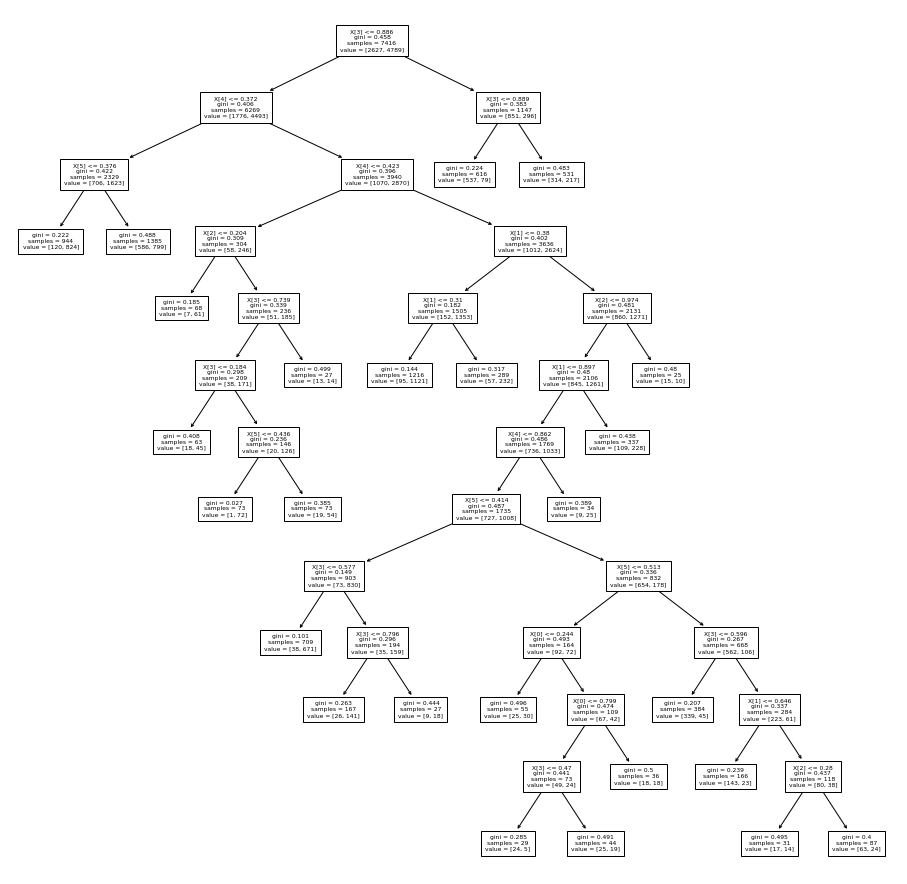

In [33]:
plt.figure(figsize=(16,16))
tree.plot_tree(lst_final[3],fontsize = 6)

# 4. Vyhodnotenie

In [31]:
filename2 = "020/labor.csv"
labor = pd.read_csv(filename2, sep='\t', index_col=0)

labor.loc[labor['smoker'] == 'yes', 'smoker']='Y'
labor.loc[labor['smoker'] == 'no', 'smoker']='N'

labor['weight']=labor['weight'].apply(abs)
labor = labor.drop_duplicates()

indic = labor['indicator']
labor.drop(labels=['indicator'], axis=1,inplace = True)
labor.insert(0,'indicator',indic)

labor = labor.reset_index(drop = True)

labor=labor.drop(['name','relationship','ssn', 'smoker'],axis=1)
labor

,indicator,er-cv,leukocyty,weight,etytr,erytrocyty,trombocyty,hemoglobin,ast,alp,alt,hematokrit,hbver
0,1.0,43.09887,4.47526,65.57593,5.96219,6.20665,5.71427,5.06667,57.92930,57.60257,5.12934,7.11081,6.32708
1,1.0,32.51734,4.41339,58.47779,5.44840,5.58217,6.29619,6.90945,61.47846,83.38342,10.59365,8.52324,9.06429
2,1.0,54.39106,4.71119,37.58396,6.75478,6.36030,6.67129,4.08668,59.37033,31.60935,10.72644,8.41874,7.11435
3,1.0,45.79943,5.38079,88.06628,6.33099,5.45784,6.24957,5.57164,50.31551,75.29715,9.26557,4.69702,7.00724
4,0.0,48.81261,4.72469,44.59816,6.62153,6.36262,6.44608,6.49617,50.44424,84.90135,9.31196,6.31221,8.54503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,1.0,57.11218,5.26323,51.27708,5.00976,4.91856,6.48513,3.03796,41.27456,13.47601,13.88191,5.86663,6.55392
9884,0.0,55.86133,8.38651,152.99318,9.27774,5.78542,4.73446,4.92447,44.92183,56.03309,8.23807,6.50680,7.18183
9885,1.0,20.08620,4.81549,89.14354,6.54037,5.12928,5.28566,7.07261,20.39526,75.88338,7.06386,5.16492,8.92604
9886,1.0,40.47220,5.28603,18.62037,6.22798,6.35608,6.37370,5.59105,18.04463,79.92407,12.06706,5.72674,8.84950


In [34]:
def my_fill_na(arg1,ind):
    labor.loc[labor['indicator'] == ind , arg1] = labor.loc[labor['indicator'] == ind , arg1].fillna(
    (labor.loc[labor['indicator'] == ind , arg1].mean()))
    
def drop_na(df):
    return df.copy().dropna()

def use_my_fill_na(atributes):
    for atribute in atributes:
        my_fill_na(atribute, 0)
        my_fill_na(atribute, 1)

In [35]:
# MISSING VALUES
# labor = drop_na(labor)
use_my_fill_na(labor.columns)

In [36]:
import random
def detect_outlier(atr):
    lower = atr.quantile(0.25) - 1.5
    upper = atr.quantile(0.75) + 1.5
    
    return atr[(atr > upper) | (atr < lower)]

def detect_upper_lower_outliers(atr):
    lower = atr.quantile(0.25) - 1.5
    upper = atr.quantile(0.75) + 1.5
    
    return atr[(atr > upper)], atr[(atr < lower)]

# Tato funkcia najde vrchnych a spodnych outlierov a vyplni ich nahodnou hodnotou medzi minimom bez outlierov a 10 spodnych % pripadne maximom bez outlierov a 10 vrchnych %
def fill_outliers(df, atr):
    df.loc[detect_upper_lower_outliers(df[atr])[0].index, [atr]] = random.uniform(df.drop(detect_upper_lower_outliers(df[atr])[0].index)[atr].quantile(0.90), df.drop(detect_upper_lower_outliers(df[atr])[0].index)[atr].max())
    df.loc[detect_upper_lower_outliers(df[atr])[1].index, [atr]] = random.uniform(df.drop(detect_upper_lower_outliers(df[atr])[1].index)[atr].min(), df.drop(detect_upper_lower_outliers(df[atr])[1].index)[atr].quantile(0.10))
    df[atr]
    
def handle_outlier(df, atributes, handle_type='fill'):
    result = df.copy()
    if handle_type == 'fill':
        for atribute in atributes:
            fill_outliers(result, atribute)
    elif handle_type == 'drop':
        for atribute in atributes:
            result.drop(detect_outlier(result[atribute]).index, inplace=True)
    else:
        print("incorrect handle_type")
    return result

In [37]:
# OUTLINERS
labor = handle_outlier(labor, labor.columns, 'fill')
# labor = handle_outlier(labor, labor.columns, 'drop')

In [38]:
# PREPROCESSING
split_by = 0.75
labor_train = labor.sample(frac=split_by,random_state=200)
labor_train.sort_index()

labor_test = labor
labor_test = pd.merge(labor_test,labor_train,indicator = True, how = 'outer').query('_merge=="left_only"').drop('_merge', axis = 1)

In [39]:
# TRANSFORMATION
atributes = labor_train.columns
def my_fit(df, scaler, atributes):
    return scaler.fit_transform(df.loc[:, atributes])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(labor_train.loc[:, atributes])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled = scaler.fit_transform(labor_train.loc[:, atributes])

# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# scaled = scaler.fit_transform(labor_train.loc[:, atributes])

# from sklearn.preprocessing import PowerTransformer
# power = PowerTransformer(method='yeo-johnson', standardize=True)
# trans = power.fit_transform(labor_train.loc[:, atributes])

# from sklearn.preprocessing import QuantileTransformer
# qt = QuantileTransformer(n_quantiles=10, random_state=0)
# labor_train = my_fit(labor_train, qt, atributes)

In [40]:
# VYBER ATRIBUTOV
k=7
labor_train =  pd.DataFrame(labor_train,columns = atributes)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

y = labor_train['indicator']
labor_train_proc = SelectKBest(mutual_info_regression, k=k).fit_transform(labor_train, y)

# Vráti array názvov stĺpcov
def get_names(w_names, wo_names):
    names = w_names.columns
    ret_val = []
    i = 0
    for x in wo_names[0]:
        j = 0
        for y in w_names.iloc[0]:
            if j<i:
                j+=1
                continue
            if x == y:
                ret_val.append(names[j])
                i = j
                break
            j+=1
    return (ret_val)

labor_train_proc = pd.DataFrame(labor_train_proc,columns = get_names(labor_train,labor_train_proc))

from numpy import arange

def get_order():
    y = labor_train_proc['indicator']
    for x in arange(2, k+1, 1):
        new_arr = SelectKBest(mutual_info_regression, k=x).fit_transform(labor_train_proc, y)
        print(get_names(labor_train, new_arr)[1:])
        
get_order()

['leukocyty']
['leukocyty', 'hematokrit']
['leukocyty', 'hemoglobin', 'hematokrit']
['leukocyty', 'trombocyty', 'hemoglobin', 'hematokrit']
['leukocyty', 'trombocyty', 'hemoglobin', 'hematokrit', 'hbver']
['leukocyty', 'trombocyty', 'hemoglobin', 'ast', 'hematokrit', 'hbver']


In [41]:
# LEARNING 2
X_train = labor_train[['er-cv','leukocyty','trombocyty','hemoglobin','ast','hematokrit']]
y_train = labor_train[['indicator']]
X_test = labor_test[['er-cv','leukocyty','trombocyty','hemoglobin','ast','hematokrit']]
y_test = labor_test[['indicator']]

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import tree

def predict_tree(i):
    if (i == 0):
        clf = DecisionTreeClassifier()
    else:
        print("Depth = ",i)
        clf = DecisionTreeClassifier(max_depth = i)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

predict_tree(8)

Depth =  8
Accuracy =  0.8697411003236246  Precision =  0.8943037974683544  Recall =  0.9011479591836735


DecisionTreeClassifier(max_depth=8)

In [42]:
# LEARNING 3
def predict_tree_MinSample(i,j):
    print("Depth = ",i," Min sample leaf = ",j)
    clf = DecisionTreeClassifier(max_depth = i,min_samples_leaf = j)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec= precision_score(y_test, pred)
    print("Accuracy = ",acc," Precision = ",prec," Recall = ",rec)
    return clf

predict_tree_MinSample(8,51)

Depth =  8  Min sample leaf =  51
Accuracy =  0.8697411003236246  Precision =  0.9077225130890052  Recall =  0.8845663265306123


DecisionTreeClassifier(max_depth=8, min_samples_leaf=51)

## VYSLEDKY
Ako defoultne budem pouzivat rozlozenie: 
- Strategia riesenia chybajucich hodnot: my_fill_na
- Strategia riesenia outlinerov: fill_outliners
- Scaling resp Transforming: MinMaxScaler
- Vyber atributov: k=7
- Ensamble learning: predict_tree_MinSample

Postupne budeme v kazdej kategorii menit vybrane algoritmy a vysledky accuracy zapisovat

### Strategia riesenia chybajucich hodnot
- my_fill_na: 0.8697411003236246
- drop_na: 0.8694560669456067

### Strategia riesenia outlinerov
- fill: 0.8697411003236246
- drop: 0.8981481481481481

### Scaling resp Transforming
- MinMaxScaler: 0.8697411003236246
- StandartScaler: 0.8685275080906149
- RobustScaler: 0.8673139158576052
- PowerTransformer: 0.8689320388349514
- QuantileTranformer: 0.3656957928802589

### Vyber Atributov
- k=3: 0.8681229773462783
- k=5: 0.8697411003236246
- k=7: 0.8697411003236246

### Ensamble learning
- OneR: 0.7148058252427184 (src: F3-uloha1.ipynb)
- PredictTree: 0.8717637540453075
- PredictTreeMinMax: 0.8677184466019418

## ZHODNOTENIE
Najlepsiu accuracy sme dosiahli pri nasledujucich nastaveniach:
- Strategia riesenia chybajucich hodnot: my_fill_na
- Strategia riesenia outlinerov: **drop_outliners**
- Scaling resp Transforming: MinMaxScaler
- Vyber atributov: k=7
- Ensamble learning: predict_tree_MinSample